<h1 style="text-align:center;">Data Science & Society Thesis</h1>
<h3 style="text-align:center;">FORECASTING CRYPTO PRICE  PEAKS: REGRESSION – BASED </h3>
<h3 style="text-align:center;">TIME – UNTIL – NEW - HIGH </h3>
<h3 style="text-align:center;">PREDICTIONS</h3>
<h5 style="text-align:center;"> ELEFTHERIOS DIAMANTIDIS</h5>

---

# **RQ 1:** ML Model Comparison

## <span style='color:brown'>**Stage A:** Preprocessing</span>

### **Step 1:** Import Libraries

In [113]:
# Import Basic Libraries
# type: ignore
import pandas as pd
import numpy as np
import matplotlib.pylab as plt   
import matplotlib.dates as mdates                                                            
import seaborn as sns                                                                        
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)        # Prevent line-wrapping

import statsmodels.api as sm
from collections import Counter
from scipy.stats import randint, uniform, loguniform

import shap

from plot_results import plot_log_results, plot_results

# Import Libraries for Time Series Analysis
from tsfresh import extract_features, select_features                                        
from tsfresh.utilities.dataframe_functions import roll_time_series, impute                   

# Import Libraries for Machine Learning
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error, r2_score          
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit                      
from sklearn.preprocessing import StandardScaler, RobustScaler                 
from sklearn.svm import SVR                                                                  
from sklearn.ensemble import RandomForestRegressor         
from quantile_forest import RandomForestQuantileRegressor
from xgboost import XGBRegressor
                                                                        

# Import Libraries for Deep Learning
from tensorflow.keras.models import Sequential, Model                                               
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam                                                 
from scikeras.wrappers import KerasRegressor                                                                       
from keras_tuner import RandomSearch   
from tensorflow.keras.optimizers import Nadam                                               
from keras.callbacks import EarlyStopping      
import kerastuner as kt  
from keras.regularizers import l2

### **Step 2:** Import data

In [114]:
df_eth = pd.read_csv("data/final_data_eth.csv")
df_eth['coin'] = 'ETH'
df_eth = df_eth.rename(columns={"Date":"date"})
df_eth["date"] = pd.to_datetime(df_eth["date"])
df_eth['Date'] = df_eth['date'].dt.date
df_eth['date'] = df_eth['date'].dt.date
df_eth = df_eth.set_index('Date')
print(df_eth.head())

                  date        Open        High         Low       Close      Volume  tunh coin
Date                                                                                         
2017-11-09  2017-11-09  308.644989  329.451996  307.056000  320.884003   893249984   5.0  ETH
2017-11-10  2017-11-10  320.670990  324.717987  294.541992  299.252991   885985984   3.0  ETH
2017-11-11  2017-11-11  298.585999  319.453003  298.191986  314.681000   842300992   2.0  ETH
2017-11-12  2017-11-12  314.690002  319.153015  298.513000  307.907990  1613479936   1.0  ETH
2017-11-13  2017-11-13  307.024994  328.415009  307.024994  316.716003  1041889984   1.0  ETH


In [115]:
df_eth.shape

(2709, 8)

### **Step 3:** Handle missing data & outliers

In [116]:
df_eth.isna().sum()

date       0
Open       0
High       0
Low        0
Close      0
Volume     0
tunh      45
coin       0
dtype: int64

In [117]:
df_eth['tunh'] = df_eth['tunh'].ffill().bfill()

In [118]:
df_eth.isna().sum()

date      0
Open      0
High      0
Low       0
Close     0
Volume    0
tunh      0
coin      0
dtype: int64

In [119]:
upper_limit = df_eth['tunh'].quantile(0.99)
df_eth['tunh_outlier'] = df_eth['tunh'] > upper_limit

# Calculate total clearly
num_outliers = df_eth['tunh_outlier'].sum()
print(f"Detected {num_outliers} outliers ({100 * num_outliers / len(df_eth):.2f}%) above the 99th percentile ({upper_limit:.2f} days).")

Detected 28 outliers (1.03%) above the 99th percentile (949.12 days).


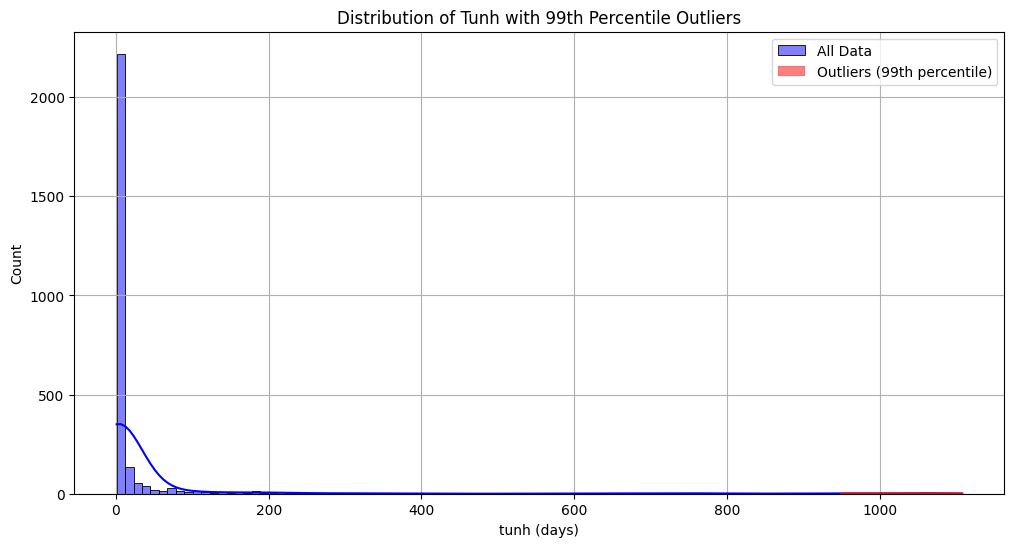

In [120]:
plt.figure(figsize=(12, 6))
sns.histplot(df_eth['tunh'], bins=100, kde=True, color='blue', label='All Data')
sns.histplot(df_eth[df_eth['tunh_outlier']]['tunh'], bins=100, kde=True, color='red', label='Outliers (99th percentile)')
plt.xlabel("tunh (days)")
plt.title("Distribution of Tunh with 99th Percentile Outliers")
plt.legend()
plt.grid(True)
plt.show()

In [121]:
df_eth = df_eth[~df_eth['tunh_outlier']].copy()
print(f"Final data shape after outlier removal: {df_eth.shape}")
df_eth.drop(columns=['tunh_outlier'], inplace=True)

Final data shape after outlier removal: (2681, 9)


### **Step 4:** Log-transform target

In [122]:
df_eth['tunh_log'] = np.log1p(df_eth['tunh'])
print(df_eth.head())

                  date        Open        High         Low       Close      Volume  tunh coin  tunh_log
Date                                                                                                   
2017-11-09  2017-11-09  308.644989  329.451996  307.056000  320.884003   893249984   5.0  ETH  1.791759
2017-11-10  2017-11-10  320.670990  324.717987  294.541992  299.252991   885985984   3.0  ETH  1.386294
2017-11-11  2017-11-11  298.585999  319.453003  298.191986  314.681000   842300992   2.0  ETH  1.098612
2017-11-12  2017-11-12  314.690002  319.153015  298.513000  307.907990  1613479936   1.0  ETH  0.693147
2017-11-13  2017-11-13  307.024994  328.415009  307.024994  316.716003  1041889984   1.0  ETH  0.693147


### **Step 5:** Plots

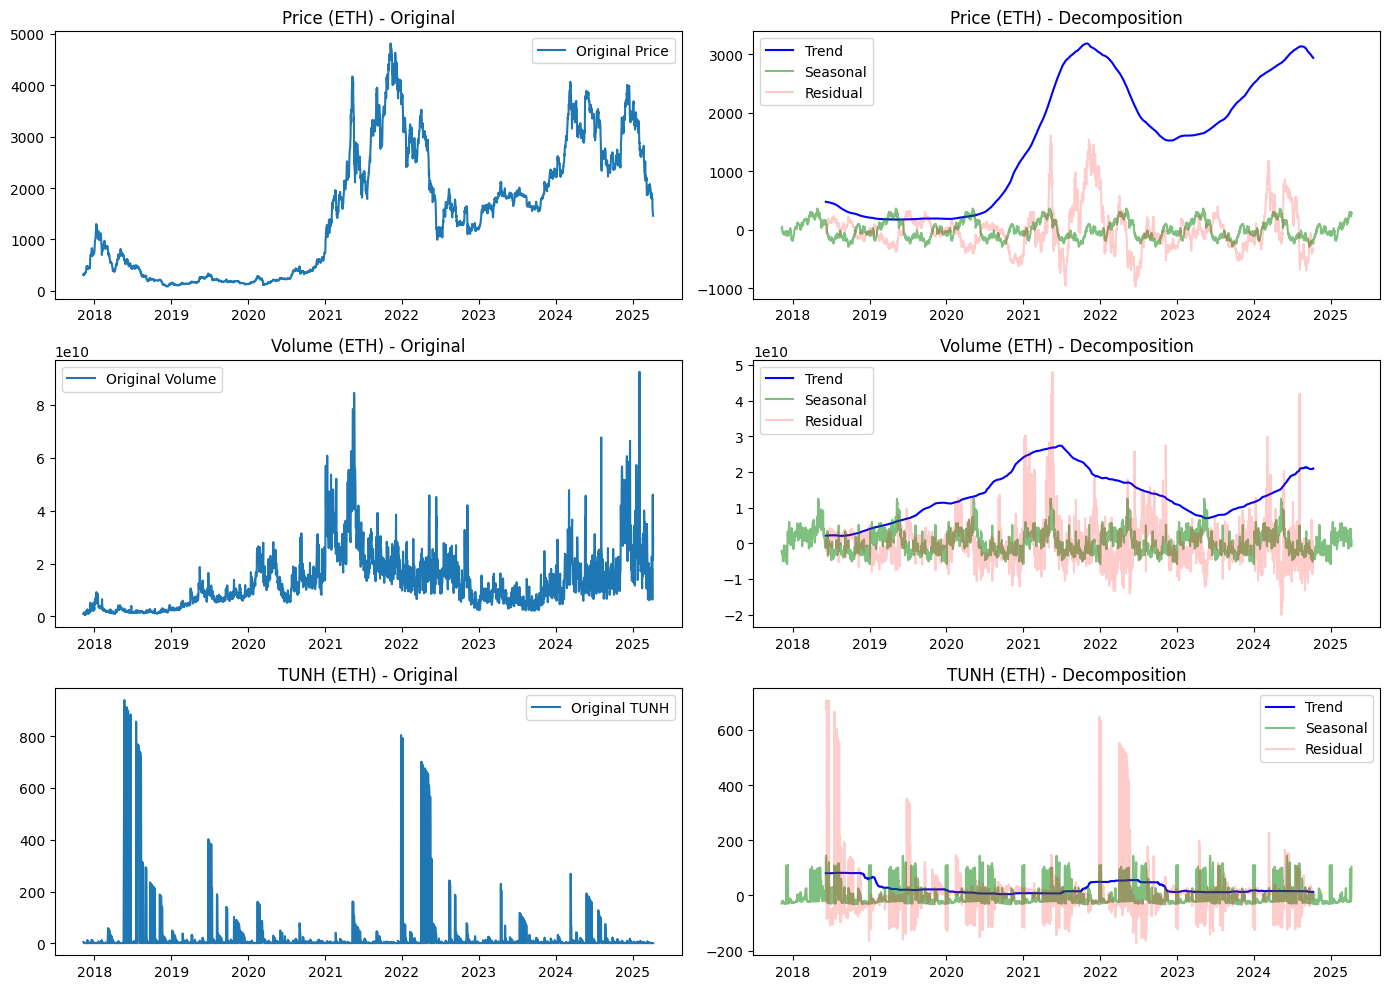

In [123]:
# Decompose the time series for 'Close', 'Volume', and 'tunh'
decomposition_price = sm.tsa.seasonal_decompose(df_eth['Close'], model='additive', period=365)
decomposition_volume = sm.tsa.seasonal_decompose(df_eth['Volume'], model='additive', period=365)
decomposition_tunh = sm.tsa.seasonal_decompose(df_eth['tunh'], model='additive', period=365)

# Create the subplots for Price, Volume, and TUNH
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

# Price (Close)
axes[0, 0].plot(df_eth['Close'], label='Original Price')
axes[0, 0].set_title('Price (ETH) - Original')
axes[0, 0].legend()

axes[0, 1].plot(decomposition_price.trend, label='Trend', color='blue')
axes[0, 1].plot(decomposition_price.seasonal, label='Seasonal', color='green', alpha=0.5)
axes[0, 1].plot(decomposition_price.resid, label='Residual', color='red', alpha=0.2)
axes[0, 1].set_title('Price (ETH) - Decomposition')
axes[0, 1].legend()

# Volume
axes[1, 0].plot(df_eth['Volume'], label='Original Volume')
axes[1, 0].set_title('Volume (ETH) - Original')
axes[1, 0].legend()

axes[1, 1].plot(decomposition_volume.trend, label='Trend', color='blue')
axes[1, 1].plot(decomposition_volume.seasonal, label='Seasonal', color='green', alpha=0.5)
axes[1, 1].plot(decomposition_volume.resid, label='Residual', color='red', alpha=0.2)
axes[1, 1].set_title('Volume (ETH) - Decomposition')
axes[1, 1].legend()

# TUNH
axes[2, 0].plot(df_eth['tunh'], label='Original TUNH')
axes[2, 0].set_title('TUNH (ETH) - Original')
axes[2, 0].legend()

axes[2, 1].plot(decomposition_tunh.trend, label='Trend', color='blue')
axes[2, 1].plot(decomposition_tunh.seasonal, label='Seasonal', color='green', alpha=0.5)
axes[2, 1].plot(decomposition_tunh.resid, label='Residual', color='red', alpha=0.2)
axes[2, 1].set_title('TUNH (ETH) - Decomposition')
axes[2, 1].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

fig.savefig('Plots/1. time_series_plots/3. decomposition_eth.png', dpi=300, bbox_inches='tight')

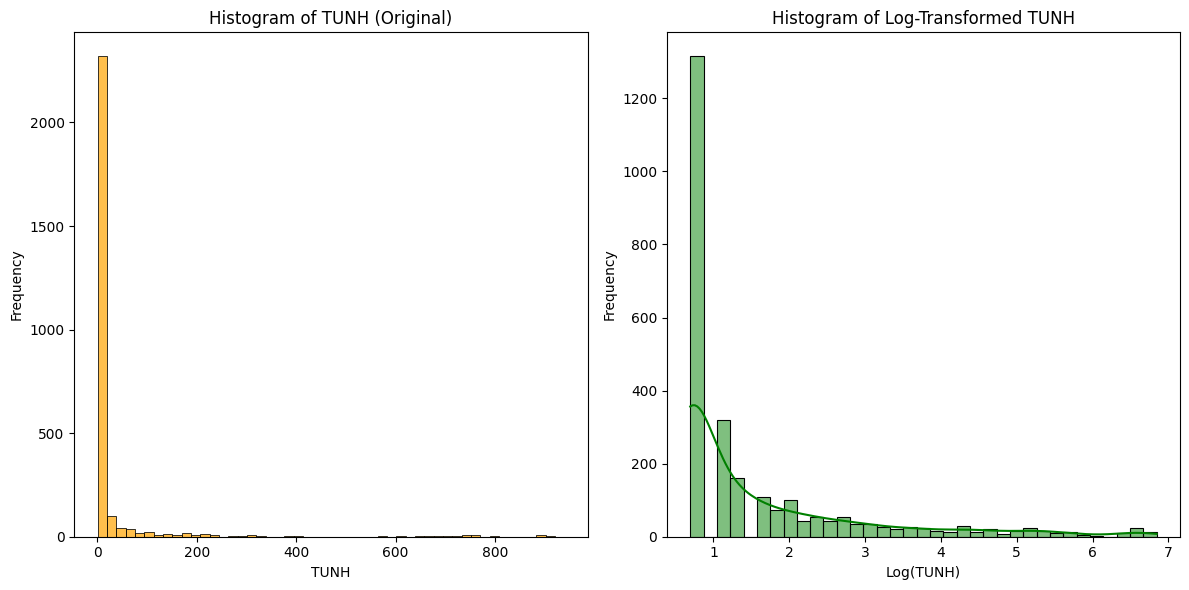

In [124]:
# Plot histogram for TUNH
plt.figure(figsize=(12, 6))

# Plot original TUNH histogram
plt.subplot(1, 2, 1)
sns.histplot(df_eth['tunh'], bins=50, color='orange', edgecolor="black", alpha=0.7)  # default Matplotlib colours
plt.title('Histogram of TUNH (Original)')
plt.xlabel('TUNH')
plt.ylabel('Frequency')

# Plot transformed TUNH (log-transformed) histogram
plt.subplot(1, 2, 2)
sns.histplot(df_eth['tunh_log'], kde=True, color='green')
plt.title('Histogram of Log-Transformed TUNH')
plt.xlabel('Log(TUNH)')
plt.ylabel('Frequency')

# Show the plots
plt.savefig('Plots/2. histograms/3. histogram_eth.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

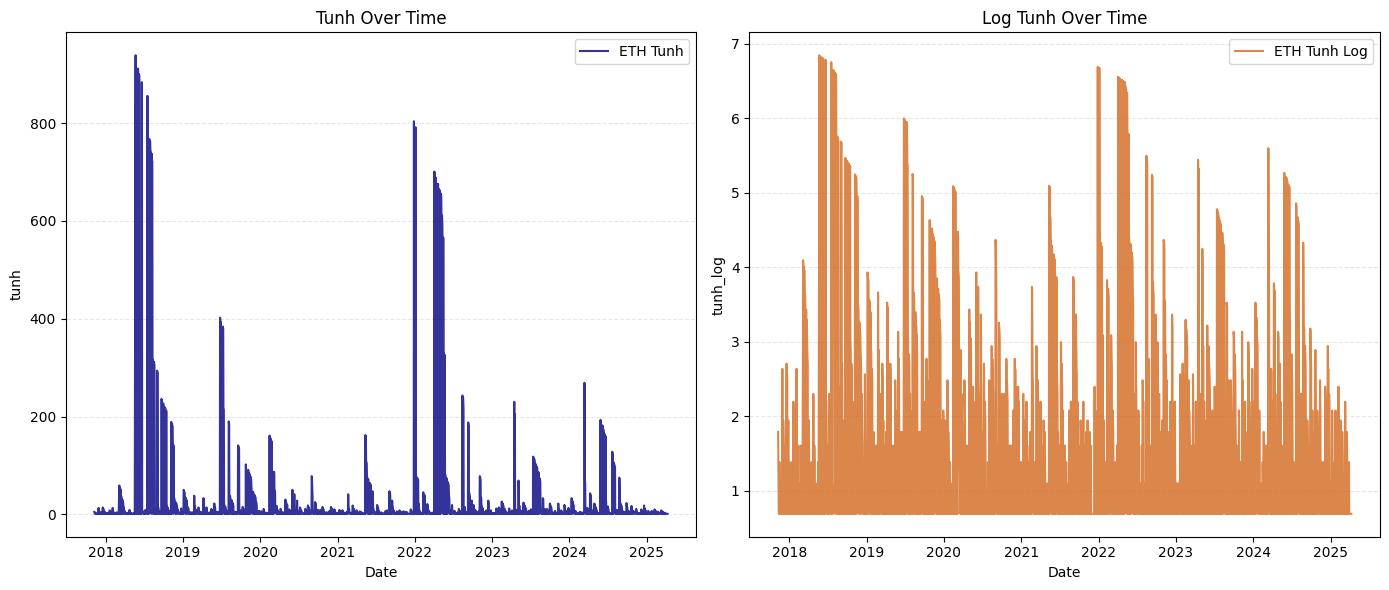

In [125]:
# Create the figure and axes for subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First plot: Tunh Over Time
sns.lineplot(x=df_eth["date"], y=df_eth["tunh"], color="navy", alpha=0.8, label="ETH Tunh", ax=axes[0])
axes[0].set_title("Tunh Over Time")
axes[0].set_xlabel('Date')
axes[0].set_ylabel('tunh')
axes[0].legend()
axes[0].grid(visible=True, alpha=0.3, linestyle='--', axis='y')
axes[0].grid(visible=False, alpha=0.0, axis='x')

# Second plot: Log Tunh Over Time
sns.lineplot(x=df_eth["date"], y=df_eth["tunh_log"], color="chocolate", alpha=0.8, label="ETH Tunh Log", ax=axes[1])
axes[1].set_title("Log Tunh Over Time")
axes[1].set_xlabel('Date')
axes[1].set_ylabel('tunh_log')
axes[1].legend()
axes[1].grid(visible=True, alpha=0.3, linestyle='--', axis='y')
axes[1].grid(visible=False, alpha=0.0, axis='x')

plt.savefig('Plots/3. lineplots/3. lineplot_eth.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

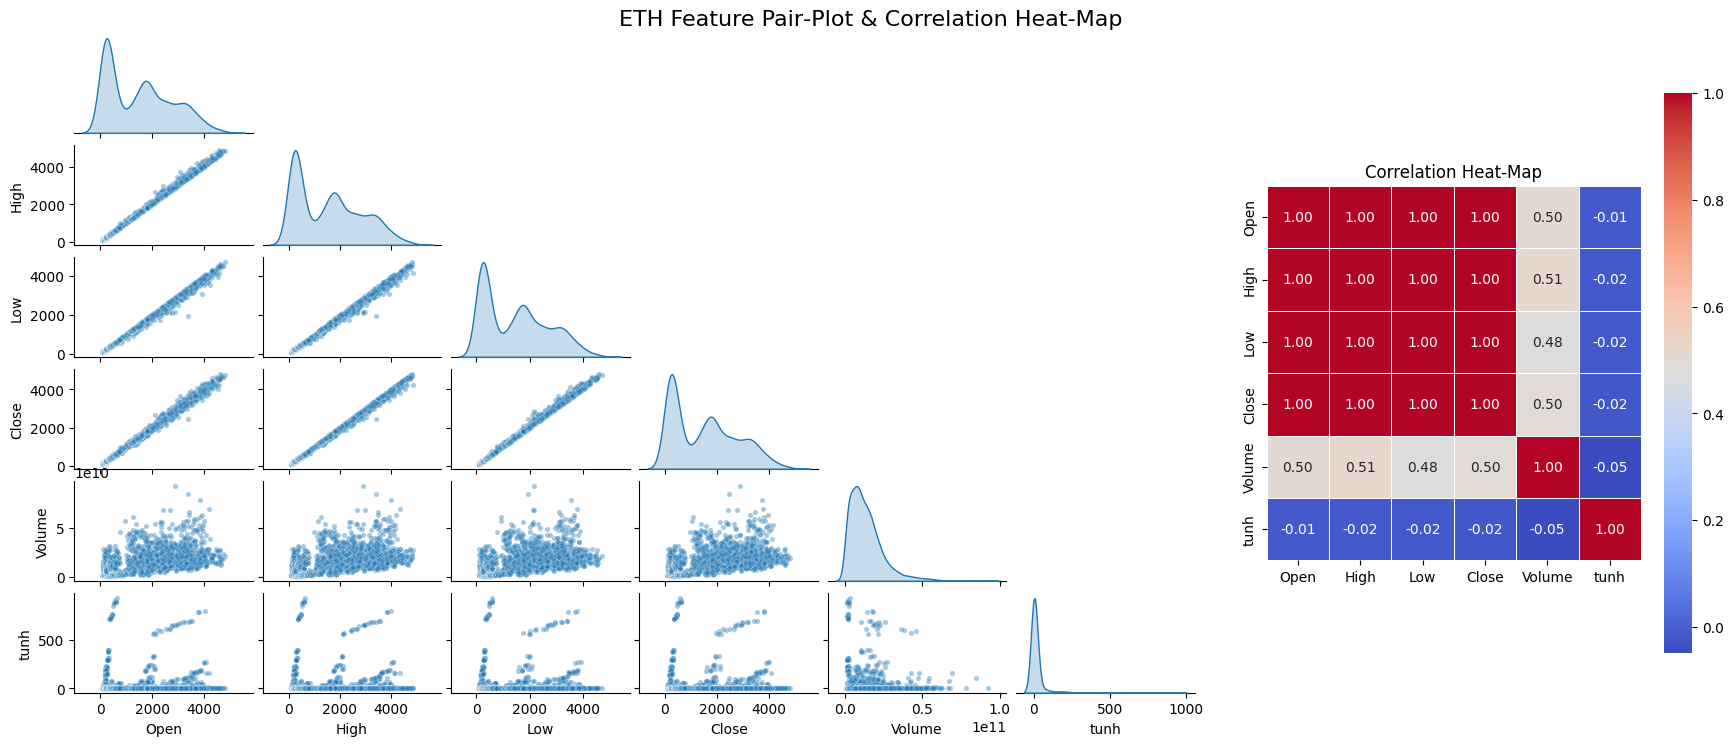

In [126]:
num_cols = ["Open", "High", "Low", "Close", "Volume", "tunh"]

g = sns.pairplot(
    df_eth[num_cols],
    diag_kind="kde",
    corner=True,
    plot_kws={"alpha": 0.4, "s": 14}
)
g.fig.set_size_inches(18, 7)          # make it wide enough

g.fig.subplots_adjust(right=0.68)     # 68 % of width → pair‑plot; rest → heat‑map

ax_heat = g.fig.add_axes([0.72, 0.10, 0.26, 0.80])   # [left, bottom, width, height]

corr = df_eth[num_cols].corr(method="pearson")
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    square=True,
    ax=ax_heat
)
ax_heat.set_title("Correlation Heat‑Map", fontsize=12)

g.fig.suptitle("ETH Feature Pair‑Plot & Correlation Heat‑Map", y=1.02, fontsize=16)
plt.savefig('Plots/4. pairplots/3. pairplot_eth.png', dpi=300, bbox_inches='tight')
plt.show()

In [127]:
df_eth = df_eth.drop(['tunh'], axis=1)

### **Step 6:** Function to calculate metrics

In [128]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    direction_true = np.sign(np.diff(y_true))
    direction_pred = np.sign(np.diff(y_pred))
    da = np.mean(direction_true == direction_pred) * 100
    return mae, rmse, mape, da

### **Step 7:** Convert to time-series

In [129]:
df_eth_rolled = roll_time_series(df_eth, column_id="coin", column_sort="date",
                            max_timeshift=20, min_timeshift=5)

Rolling: 100%|██████████| 20/20 [00:04<00:00,  4.32it/s]


In [130]:
print(df_eth_rolled.head())
print("\nLen of df_rolled:",len(df_eth_rolled))
print("Unique id's:",df_eth_rolled["id"].nunique())

         date        Open        High         Low       Close      Volume coin  tunh_log                 id
0  2017-11-09  308.644989  329.451996  307.056000  320.884003   893249984  ETH  1.791759  (ETH, 2017-11-14)
1  2017-11-10  320.670990  324.717987  294.541992  299.252991   885985984  ETH  1.386294  (ETH, 2017-11-14)
2  2017-11-11  298.585999  319.453003  298.191986  314.681000   842300992  ETH  1.098612  (ETH, 2017-11-14)
3  2017-11-12  314.690002  319.153015  298.513000  307.907990  1613479936  ETH  0.693147  (ETH, 2017-11-14)
4  2017-11-13  307.024994  328.415009  307.024994  316.716003  1041889984  ETH  0.693147  (ETH, 2017-11-14)

Len of df_rolled: 56076
Unique id's: 2676


### **Step 8:** Feature extraction

In [131]:
X = extract_features(df_eth_rolled.drop("coin", axis=1), 
                    column_id="id", column_sort="date", column_value="tunh_log", 
                    impute_function=impute, show_warnings=False)

Feature Extraction: 100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


### **Step 9:** Split the data

In [132]:
X = X.set_index(X.index.map(lambda x: x[1]), drop=True)
X.index.name = "last_date"
X.head()

,tunh_log__variance_larger_than_standard_deviation,tunh_log__has_duplicate_max,tunh_log__has_duplicate_min,tunh_log__has_duplicate,tunh_log__sum_values,tunh_log__abs_energy,tunh_log__mean_abs_change,tunh_log__mean_change,tunh_log__mean_second_derivative_central,tunh_log__median,tunh_log__mean,tunh_log__length,tunh_log__standard_deviation,tunh_log__variation_coefficient,tunh_log__variance,tunh_log__skewness,tunh_log__kurtosis,tunh_log__root_mean_square,tunh_log__absolute_sum_of_changes,tunh_log__longest_strike_below_mean,tunh_log__longest_strike_above_mean,tunh_log__count_above_mean,tunh_log__count_below_mean,tunh_log__last_location_of_maximum,tunh_log__first_location_of_maximum,tunh_log__last_location_of_minimum,tunh_log__first_location_of_minimum,tunh_log__percentage_of_reoccurring_values_to_all_values,tunh_log__percentage_of_reoccurring_datapoints_to_all_datapoints,tunh_log__sum_of_reoccurring_values,tunh_log__sum_of_reoccurring_data_points,tunh_log__ratio_value_number_to_time_series_length,tunh_log__sample_entropy,tunh_log__maximum,tunh_log__absolute_maximum,tunh_log__minimum,tunh_log__benford_correlation,tunh_log__time_reversal_asymmetry_statistic__lag_1,tunh_log__time_reversal_asymmetry_statistic__lag_2,tunh_log__time_reversal_asymmetry_statistic__lag_3,tunh_log__c3__lag_1,tunh_log__c3__lag_2,tunh_log__c3__lag_3,tunh_log__cid_ce__normalize_True,tunh_log__cid_ce__normalize_False,tunh_log__symmetry_looking__r_0.0,tunh_log__symmetry_looking__r_0.05,tunh_log__symmetry_looking__r_0.1,tunh_log__symmetry_looking__r_0.15000000000000002,tunh_log__symmetry_looking__r_0.2,tunh_log__symmetry_looking__r_0.25,tunh_log__symmetry_looking__r_0.30000000000000004,tunh_log__symmetry_looking__r_0.35000000000000003,tunh_log__symmetry_looking__r_0.4,tunh_log__symmetry_looking__r_0.45,tunh_log__symmetry_looking__r_0.5,tunh_log__symmetry_looking__r_0.55,tunh_log__symmetry_looking__r_0.6000000000000001,tunh_log__symmetry_looking__r_0.65,tunh_log__symmetry_looking__r_0.7000000000000001,tunh_log__symmetry_looking__r_0.75,tunh_log__symmetry_looking__r_0.8,tunh_log__symmetry_looking__r_0.8500000000000001,tunh_log__symmetry_looking__r_0.9,tunh_log__symmetry_looking__r_0.9500000000000001,tunh_log__large_standard_deviation__r_0.05,tunh_log__large_standard_deviation__r_0.1,tunh_log__large_standard_deviation__r_0.15000000000000002,tunh_log__large_standard_deviation__r_0.2,tunh_log__large_standard_deviation__r_0.25,tunh_log__large_standard_deviation__r_0.30000000000000004,tunh_log__large_standard_deviation__r_0.35000000000000003,tunh_log__large_standard_deviation__r_0.4,tunh_log__large_standard_deviation__r_0.45,tunh_log__large_standard_deviation__r_0.5,tunh_log__large_standard_deviation__r_0.55,tunh_log__large_standard_deviation__r_0.6000000000000001,tunh_log__large_standard_deviation__r_0.65,tunh_log__large_standard_deviation__r_0.7000000000000001,tunh_log__large_standard_deviation__r_0.75,tunh_log__large_standard_deviation__r_0.8,tunh_log__large_standard_deviation__r_0.8500000000000001,tunh_log__large_standard_deviation__r_0.9,tunh_log__large_standard_deviation__r_0.9500000000000001,tunh_log__quantile__q_0.1,tunh_log__quantile__q_0.2,tunh_log__quantile__q_0.3,tunh_log__quantile__q_0.4,tunh_log__quantile__q_0.6,tunh_log__quantile__q_0.7,tunh_log__quantile__q_0.8,tunh_log__quantile__q_0.9,tunh_log__autocorrelation__lag_0,tunh_log__autocorrelation__lag_1,tunh_log__autocorrelation__lag_2,tunh_log__autocorrelation__lag_3,tunh_log__autocorrelation__lag_4,tunh_log__autocorrelation__lag_5,tunh_log__autocorrelation__lag_6,tunh_log__autocorrelation__lag_7,tunh_log__autocorrelation__lag_8,tunh_log__autocorrelation__lag_9,"tunh_log__agg_autocorrelation__f_agg_""mean""__maxlag_40","tunh_log__agg_autocorrelation__f_agg_""median""__maxlag_40","tunh_log__agg_autocorrelation__f_agg_""var""__maxlag_40",tunh_log__partial_autocorrelation__lag_0,tunh_log__partial_autocorrelation__lag_1,tunh_log__partial_autocorrelation__lag_2,tunh_log__partial_autocorrelation__lag_3,tunh_log

In [133]:
y = df_eth.set_index("date").sort_index().tunh_log.shift(-1)

In [134]:
y = y.dropna()
y.isna().sum()

0

In [135]:
y = y[y.index.isin(X.index)]
X = X[X.index.isin(y.index)]

## <span style='color:brown'>**Stage B:** Modelling</span>

### <span style='color:darkgoldenrod'>**Model 1 (Baseline):** Support Vector Regressor</span>

#### **Step 1:** Split the data for the SVR (80% Train - Next 10% Validation - 10% Test)

In [136]:
# ─── 1) SPLIT & SCALE ──────────────────────────────────────────────────────
split_index = int(len(X) * 0.80)
wf_index    = int(len(X) * 0.90)

X_tr_raw = X.iloc[:split_index]
X_wf_raw = X.iloc[split_index:wf_index]
X_te_raw = X.iloc[wf_index:]

scaler = StandardScaler().fit(X_tr_raw)
X_train_svr  = pd.DataFrame(scaler.transform(X_tr_raw), index=X_tr_raw.index,  columns=X.columns)
X_wf_svr  = pd.DataFrame(scaler.transform(X_wf_raw), index=X_wf_raw.index,  columns=X.columns)
X_test_svr  = pd.DataFrame(scaler.transform(X_te_raw), index=X_te_raw.index,  columns=X.columns)

y_train_svr = y.reindex(X_train_svr.index).dropna()
X_train_svr = X_train_svr.loc[y_train_svr.index]
y_wf_svr = y.reindex(X_wf_svr.index).dropna()
X_wf_svr = X_wf_svr.loc[y_wf_svr.index]
y_test_svr = y.reindex(X_test_svr.index).dropna()
X_test_svr = X_test_svr.loc[y_test_svr.index]

In [137]:
print("Train date range:", X_train_svr.index.min(), "to", X_train_svr.index.max())
print("Walk-forward date range:", X_wf_svr.index.min(), "to", X_wf_svr.index.max())
print("Test date range:", X_test_svr.index.min(), "to", X_test_svr.index.max())

Train date range: 2017-11-14 to 2023-10-21
Walk-forward date range: 2023-10-22 to 2024-07-14
Test date range: 2024-07-15 to 2025-04-08


In [138]:
print("Train samples:", len(X_train_svr))
print("Walk-forward samples:", len(X_wf_svr))
print("Test samples:", len(X_test_svr))

Train samples: 2140
Walk-forward samples: 267
Test samples: 268


#### **Step 2:** SVR Feature Selection

In [139]:
selected = select_features(X_train_svr, y_train_svr).columns
X_train_selected_svr = X_train_svr[selected]
X_wf_selected_svr = X_wf_svr[selected]
X_test_selected_svr = X_test_svr[selected]

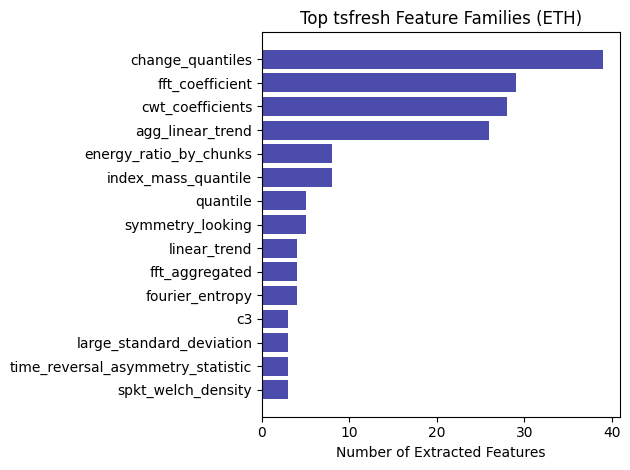

In [140]:
feature_families = []
for col in X_train_selected_svr.columns:
    parts = col.split("__")
    feature_families.append(parts[1] if len(parts) >= 2 else "other")

family_counts = Counter(feature_families)
families, counts = zip(*family_counts.most_common(15))   # top‑15

coverage = (
    df_eth_rolled.groupby("date")["id"]
    .nunique()
    .sort_index()
)

plt.barh(list(families)[::-1], list(counts)[::-1], color="darkblue", alpha=0.7)
plt.title("Top tsfresh Feature Families (ETH)")
plt.xlabel("Number of Extracted Features")

fig.suptitle("Feature‑Extraction Diagnostics", fontsize=15, y=1.02)
plt.savefig('Plots/5. top features/3. top_features_eth.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

#### **Step 3:** SVR Train

In [141]:
# ─── 3) ADD REGIME FLAG AS FEATURE ────────────────────────────────────────
# regime = 1 if next‐day TUNH faster (i.e. diff<0), else 0
reg_tr = (y_train_svr.diff().shift(-1) < 0).astype(int)
reg_wf = (y_wf_svr.diff().shift(-1) < 0).astype(int)
reg_te = (y_test_svr.diff().shift(-1) < 0).astype(int)

X_train_reg_svr = X_train_selected_svr.copy(); X_train_reg_svr['regime'] = reg_tr
X_wf_reg_svr = X_wf_selected_svr.copy(); X_wf_reg_svr['regime'] = reg_wf
X_test_reg_svr = X_test_selected_svr.copy(); X_test_reg_svr['regime'] = reg_te

In [142]:
def expand_with_regime_interactions(X, reg):
    X_exp = pd.DataFrame(index=X.index)
    # the “global” features:
    X_exp[X.columns] = X
    # bull‑only features (zero in bear)
    X_exp[[f"{c}_bull" for c in X.columns]] = X.values * reg.values[:,None]
    # bear‑only features (zero in bull)
    X_exp[[f"{c}_bear" for c in X.columns]] = X.values * (1 - reg.values)[:,None]
    return X_exp

X_train_int_svr = expand_with_regime_interactions(X_train_selected_svr, reg_tr)
X_wf_int_svr = expand_with_regime_interactions(X_wf_selected_svr, reg_wf)
X_test_int_svr = expand_with_regime_interactions(X_test_selected_svr, reg_te)

In [143]:
svr = SVR(kernel="poly", C=1.0, epsilon=0.1, gamma="scale", degree=2)
svr.fit(X_train_int_svr, y_train_svr)

SVR(degree=2, kernel='poly')

#### **Step 4:** SVR Walk-Forward Validation

In [144]:
# ─── 5) WALK‐FORWARD PREDICTIONS ───────────────────────────────────────────
fold_preds, fold_actuals, fold_indices = [], [], []
window_size = 50
start = 0

while start + window_size <= len(X_wf_int_svr):
    idx = X_wf_int_svr.index[start:start+window_size]
    X_win = X_wf_int_svr.loc[idx]
    y_win = y_wf_svr.loc[idx]
    preds = svr.predict(X_win)
    fold_preds.append(preds)
    fold_actuals.append(y_win.values)
    fold_indices.append(idx)
    # print per‐window metrics
    MAE, RMSE, MAPE, DA = calculate_metrics(y_win.values, preds)
    print(f"WF window ending at {idx[-1]}: MAE={MAE:.4f}, RMSE={RMSE:.4f}, MAPE={MAPE:.2f}%, DA={DA:.2f}%")
    start += window_size

WF window ending at 2023-12-10: MAE=0.2760, RMSE=0.4456, MAPE=22.74%, DA=63.27%
WF window ending at 2024-01-29: MAE=0.3520, RMSE=0.5568, MAPE=20.44%, DA=53.06%
WF window ending at 2024-03-19: MAE=0.2839, RMSE=0.6458, MAPE=16.71%, DA=46.94%
WF window ending at 2024-05-08: MAE=0.4476, RMSE=0.6723, MAPE=25.77%, DA=55.10%
WF window ending at 2024-06-27: MAE=0.6193, RMSE=1.1241, MAPE=33.04%, DA=65.31%


#### **Step 5:** Evaluate SVR

In [145]:
# ─── 6) FINAL TEST PREDICTION & EVALUATION ────────────────────────────────
y_train_pred_svr = svr.predict(X_train_int_svr)
y_test_pred_svr = svr.predict(X_test_int_svr)

# overall test metrics
MAE_train_svr, RMSE_train_svr, MAPE_train_svr, DA_train_svr = calculate_metrics(y_train_svr.values, y_train_pred_svr)
MAE_test_svr, RMSE_test_svr, MAPE_test_svr, DA_test_svr = calculate_metrics(y_test_svr.values, y_test_pred_svr)

print("SVR Train Metrics:")
print(f" MAE={MAE_train_svr:.5f}, RMSE={RMSE_train_svr:.5f}, MAPE={MAPE_train_svr:.2f}%, DA={DA_train_svr:.2f}%")

print("\nSVR Test Metrics:")
print(f" MAE={MAE_test_svr:.5f}, RMSE={RMSE_test_svr:.5f}, MAPE={MAPE_test_svr:.2f}%, DA={DA_test_svr:.2f}%")

SVR Train Metrics:
 MAE=0.29373, RMSE=0.64327, MAPE=17.38%, DA=64.14%

SVR Test Metrics:
 MAE=0.31916, RMSE=0.61470, MAPE=22.01%, DA=58.43%


In [146]:
# 1) WALK‑FORWARD DataFrame
df_wf_results = pd.DataFrame({
    "Actual": np.concatenate(fold_actuals),
    "Predicted": np.concatenate(fold_preds)
}, index=pd.DatetimeIndex(np.concatenate(fold_indices)))

# 2) FINAL TEST DataFrame
#   - y_te and pred_te are your true & predicted log‑TUNH for the test period
df_test_results = pd.DataFrame({
    "Actual":  y_test_svr.values,
    "Predicted": y_test_pred_svr
}, index=X_test_selected_svr.index)

# 3) convert back to days
df_test_day = df_test_results.copy()
df_test_day["Actual_days"]    = np.expm1(df_test_day["Actual"])
df_test_day["Predicted_days"] = np.expm1(df_test_day["Predicted"])
print("\nTest Results (in days):")
print(df_test_day.head())


Test Results (in days):
              Actual  Predicted  Actual_days  Predicted_days
last_date                                                   
2024-07-15  0.693147   0.738825          1.0        1.093474
2024-07-16  1.098612   1.555718          2.0        3.738486
2024-07-17  0.693147   0.726303          1.0        1.067424
2024-07-18  1.098612   1.508240          2.0        3.518769
2024-07-19  0.693147   0.715624          1.0        1.045464


#### **Step 6:** SVR Plots

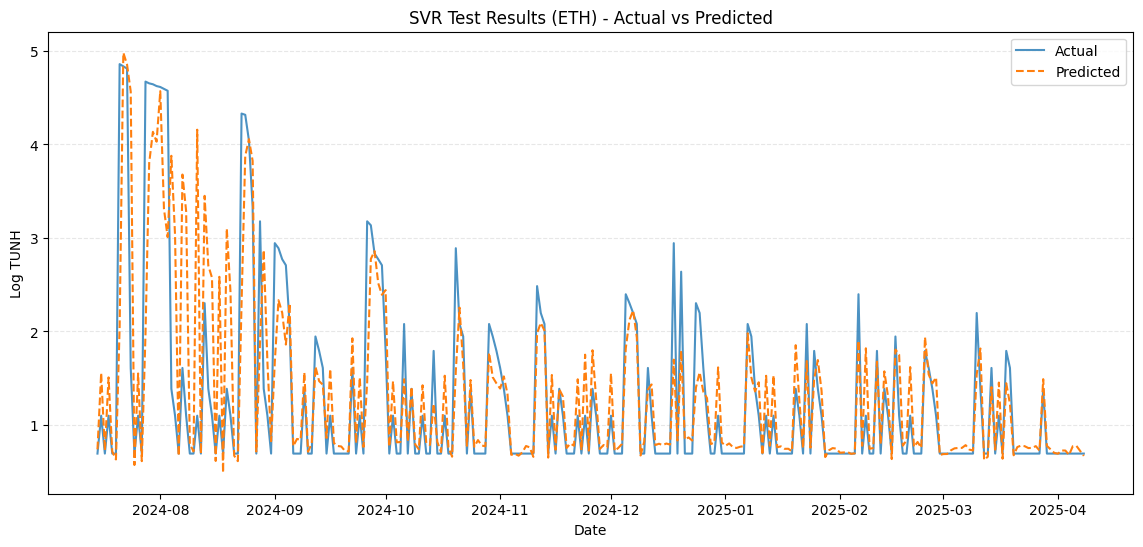

In [147]:
plot_log_results(
    df_test_results,
    "SVR Test Results (ETH) - Actual vs Predicted",
    "Log TUNH",
    'Plots/6. test results/1. svr/3a. test_results_log_eth.png'
)

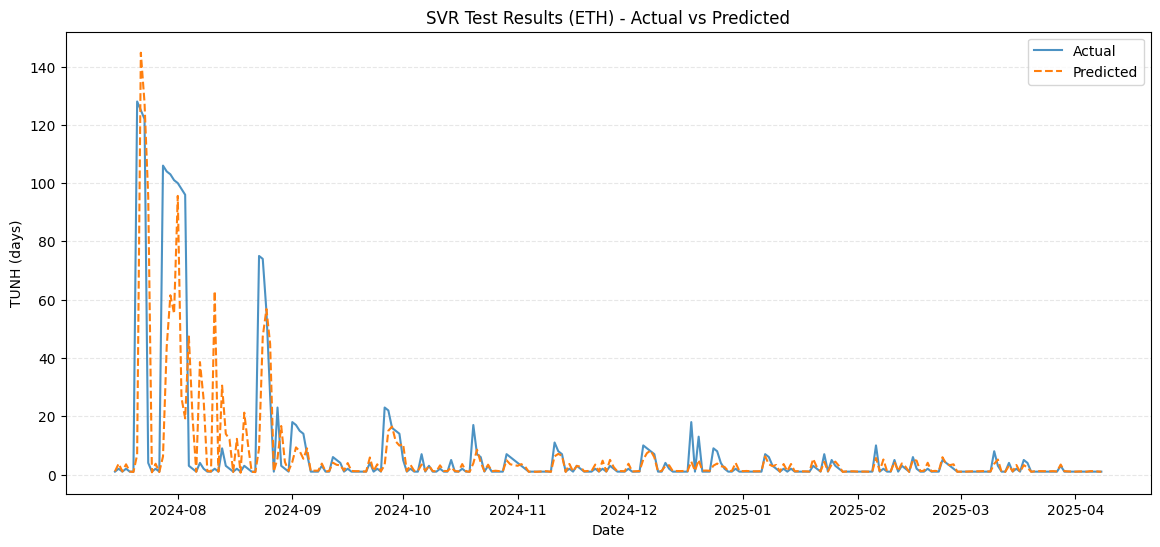

In [148]:
plot_results(
    df_test_day,
    "SVR Test Results (ETH) - Actual vs Predicted",
    "TUNH (days)",
    'Plots/6. test results/1. svr/3b. test_results_eth.png'
)

### <span style='color:darkgoldenrod'>**Model 2:** Random Forest Regressor</span>

#### **Step 1:** Split the data for the Random Forest (80% Train - Next 90% Validation - 10% Test)

In [149]:
# ─── 1) SPLIT & SCALE ──────────────────────────────────────────────────────
split_index = int(len(X) * 0.80)
wf_index    = int(len(X) * 0.90)

X_tr_raw = X.iloc[:split_index]
X_wf_raw = X.iloc[split_index:wf_index]
X_te_raw = X.iloc[wf_index:]

scaler = StandardScaler().fit(X_tr_raw)
X_train_rf  = pd.DataFrame(scaler.transform(X_tr_raw), index=X_tr_raw.index,  columns=X.columns)
X_wf_rf  = pd.DataFrame(scaler.transform(X_wf_raw), index=X_wf_raw.index,  columns=X.columns)
X_test_rf  = pd.DataFrame(scaler.transform(X_te_raw), index=X_te_raw.index,  columns=X.columns)

y_train_rf = y.reindex(X_train_rf.index).dropna()
X_train_rf = X_train_rf.loc[y_train_rf.index]
y_wf_rf = y.reindex(X_wf_rf.index).dropna()
X_wf_rf = X_wf_rf.loc[y_wf_rf.index]
y_test_rf = y.reindex(X_test_rf.index).dropna()
X_test_rf = X_test_rf.loc[y_test_rf.index]

#### **Step 2:** Random Forest Feature Selection

In [150]:
selected = select_features(X_train_rf, y_train_rf).columns
X_train_selected_rf = X_train_rf[selected]
X_wf_selected_rf = X_wf_rf[selected]
X_test_selected_rf = X_test_rf[selected]

#### **Step 3:** Random Forest Hyperparameter Tuning

In [151]:
# ─── 3) ADD REGIME FLAG AS FEATURE ────────────────────────────────────────
# regime = 1 if next‐day TUNH faster (i.e. diff<0), else 0
reg_tr = (y_train_rf.diff().shift(-1) < 0).astype(int)
reg_wf = (y_wf_rf.diff().shift(-1) < 0).astype(int)
reg_te = (y_test_rf.diff().shift(-1) < 0).astype(int)

X_train_reg_rf = X_train_selected_rf.copy(); X_train_reg_rf['regime'] = reg_tr
X_wf_reg_rf = X_wf_selected_rf.copy(); X_wf_reg_rf['regime'] = reg_wf
X_test_reg_rf = X_test_selected_rf.copy(); X_test_reg_rf['regime'] = reg_te

In [152]:
X_train_int_rf = expand_with_regime_interactions(X_train_selected_rf, reg_tr)
X_wf_int_rf = expand_with_regime_interactions(X_wf_selected_rf, reg_wf)
X_test_int_rf = expand_with_regime_interactions(X_test_selected_rf, reg_te)

In [41]:
# Setup the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Hyperparameter grid
param_dist_rf = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 4, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Randomized Search for hyperparameter tuning
random_search_rf = RandomizedSearchCV(rf, param_distributions=param_dist_rf, n_iter=20, cv=tscv, verbose=2, random_state=42, n_jobs=-1)

#### **Step 4:** Random Forest Training

In [41]:
# Best model
random_search_rf.fit(X_train_int_rf, y_train_rf)
best_rf = random_search_rf.best_estimator_
print("Best parameters for RF with TimeSeriesSplit:", random_search_rf.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  51.0s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 1.4min
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time= 2.2min
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=  53.6s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time= 3.9min
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 4.0min
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time= 4.8min
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total tim

In [153]:
best_rf = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=10, min_samples_leaf=4, bootstrap=True, random_state=42)
# # Best model
best_rf.fit(X_train_int_rf, y_train_rf)

RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                      n_estimators=200, random_state=42)

#### **Step 5:** Random Forest Walk-Forward Validation

In [154]:
# ─── C) WALK‑FORWARD EVALUATION ─────────────────────────────────────────────
fold_preds, fold_actuals, fold_indices = [], [], []
window_size = 50
for start in range(0, len(X_wf_int_rf), window_size):
    idx = X_wf_int_rf.index[start:start+window_size]
    X_win = X_wf_int_rf.loc[idx]
    y_win = y_wf_rf.loc[idx]
    preds = best_rf.predict(X_win)
    fold_preds.append(preds)
    fold_actuals.append(y_win.values)
    fold_indices.append(idx)
    MAE, RMSE, MAPE, DA = calculate_metrics(y_win.values, preds)
    print(f"WF ending {idx[-1]}: MAE={MAE:.4f}, RMSE={RMSE:.4f}, MAPE={MAPE:.2f}%, DA={DA:.2f}%")

WF ending 2023-12-10: MAE=0.2934, RMSE=0.5024, MAPE=21.42%, DA=95.92%
WF ending 2024-01-29: MAE=0.2717, RMSE=0.4785, MAPE=12.56%, DA=89.80%
WF ending 2024-03-19: MAE=0.3179, RMSE=0.7075, MAPE=15.10%, DA=89.80%
WF ending 2024-05-08: MAE=0.3113, RMSE=0.5397, MAPE=14.40%, DA=89.80%
WF ending 2024-06-27: MAE=0.6578, RMSE=1.0786, MAPE=31.45%, DA=79.59%
WF ending 2024-07-14: MAE=0.1422, RMSE=0.2345, MAPE=8.09%, DA=100.00%


#### **Step 6:** Evaluate Random Forest

In [155]:
# ─── 6) FINAL TEST PREDICTION & EVALUATION ────────────────────────────────
y_train_pred_rf = best_rf.predict(X_train_int_rf)
y_test_pred_rf = best_rf.predict(X_test_int_rf)

# overall test metrics
MAE_train_rf, RMSE_train_rf, MAPE_train_rf, DA_train_rf = calculate_metrics(y_train_rf.values, y_train_pred_rf)
MAE_test_rf, RMSE_test_rf, MAPE_test_rf, DA_test_rf = calculate_metrics(y_test_rf.values, y_test_pred_rf)

print("RF Train Metrics:")
print(f" MAE={MAE_train_rf:.5f}, RMSE={RMSE_train_rf:.5f}, MAPE={MAPE_train_rf:.2f}%, DA={DA_train_rf:.2f}%")

print("\nRF Test Metrics:")
print(f" MAE={MAE_test_rf:.5f}, RMSE={RMSE_test_rf:.5f}, MAPE={MAPE_test_rf:.2f}%, DA={DA_test_rf:.2f}%")

RF Train Metrics:
 MAE=0.24977, RMSE=0.50021, MAPE=13.14%, DA=90.79%

RF Test Metrics:
 MAE=0.25222, RMSE=0.51090, MAPE=15.24%, DA=92.51%


In [156]:
# 1) WALK‑FORWARD DataFrame
#   - y_wf_all, y_wf_pred, idx_wf_all came from the regime‑split loop
df_wf_results = pd.DataFrame({
    "Actual": np.concatenate(fold_actuals),
    "Predicted": np.concatenate(fold_preds)
}, index=pd.DatetimeIndex(np.concatenate(fold_indices)))

# 2) FINAL TEST DataFrame
#   - y_te and pred_te are your true & predicted log‑TUNH for the test period
df_test_results = pd.DataFrame({
    "Actual":  y_test_rf.values,
    "Predicted": y_test_pred_rf
}, index=X_test_selected_rf.index)

# 3) convert back to days
df_test_days = df_test_results.copy()
df_test_days["Actual_days"]    = np.expm1(df_test_days["Actual"])
df_test_days["Predicted_days"] = np.expm1(df_test_days["Predicted"])
print("\nTest Results (in days):")
print(df_test_days.head())


Test Results (in days):
              Actual  Predicted  Actual_days  Predicted_days
last_date                                                   
2024-07-15  0.693147   0.693147          1.0        1.000000
2024-07-16  1.098612   1.795065          2.0        5.019864
2024-07-17  0.693147   0.693147          1.0        1.000000
2024-07-18  1.098612   1.772214          2.0        4.883867
2024-07-19  0.693147   0.693147          1.0        1.000000


#### **Step 7:** Random Forest Plots

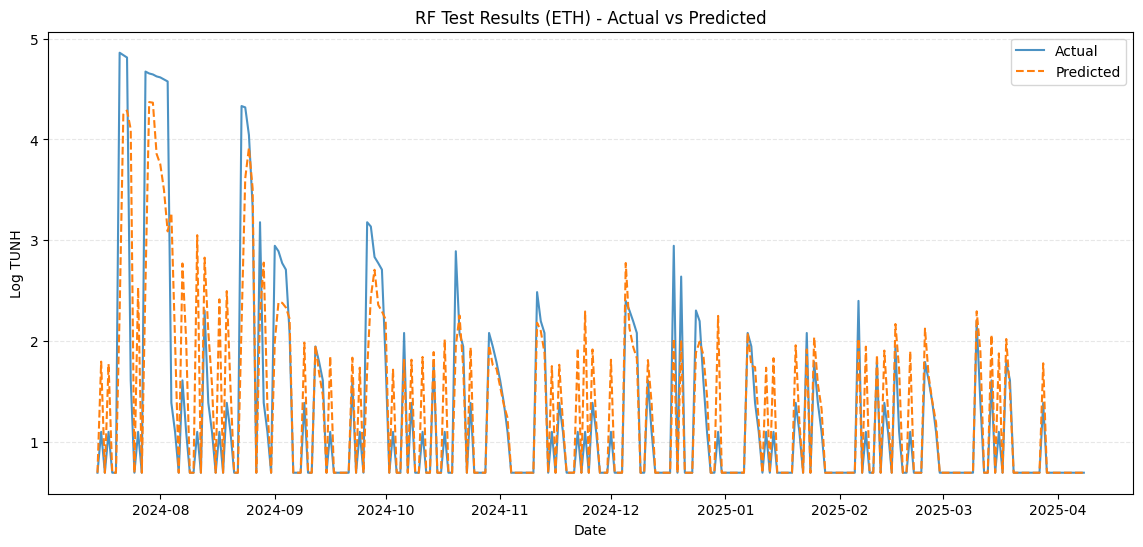

In [157]:
plot_log_results(
    df_test_results,
    "RF Test Results (ETH) - Actual vs Predicted",
    "Log TUNH",
    'Plots/6. test results/2. rf/3a. test_results_log_eth.png'
)

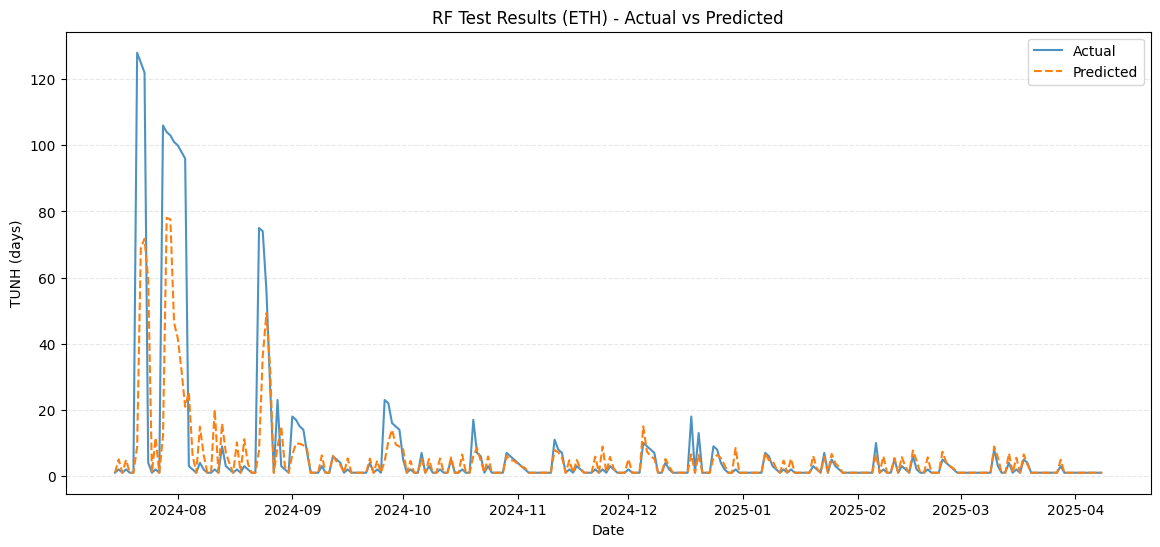

In [158]:
plot_results(
    df_test_days,
    "RF Test Results (ETH) - Actual vs Predicted",
    "TUNH (days)",
    'Plots/6. test results/2. rf/3b. test_results_eth.png'
)

### <span style='color:darkgoldenrod'>**Model 3:** XBoost Regressor</span>

#### **Step 1:** Split the data for the XGBoost (80% Train - Next 10% Validation - 10% Test)

In [48]:
# ─── 1) SPLIT & SCALE ──────────────────────────────────────────────────────
split_index = int(len(X) * 0.80)
wf_index    = int(len(X) * 0.90)

X_tr_raw = X.iloc[:split_index]
X_wf_raw = X.iloc[split_index:wf_index]
X_te_raw = X.iloc[wf_index:]

scaler = StandardScaler().fit(X_tr_raw)
X_train_xgb  = pd.DataFrame(scaler.transform(X_tr_raw), index=X_tr_raw.index,  columns=X.columns)
X_wf_xgb  = pd.DataFrame(scaler.transform(X_wf_raw), index=X_wf_raw.index,  columns=X.columns)
X_test_xgb  = pd.DataFrame(scaler.transform(X_te_raw), index=X_te_raw.index,  columns=X.columns)

y_train_xgb = y.reindex(X_train_xgb.index).dropna()
X_train_xgb = X_train_xgb.loc[y_train_xgb.index]
y_wf_xgb = y.reindex(X_wf_xgb.index).dropna()
X_wf_xgb = X_wf_xgb.loc[y_wf_xgb.index]
y_test_xgb = y.reindex(X_test_xgb.index).dropna()
X_test_xgb = X_test_xgb.loc[y_test_xgb.index]

#### **Step 2:** XGBoost Feature Selection

In [49]:
# 2) FEATURE SELECTION
selected = select_features(X_train_xgb, y_train_xgb).columns
X_train_selected_xgb = X_train_xgb[selected]
X_wf_selected_xgb = X_wf_xgb[selected]
X_test_selected_xgb = X_test_xgb[selected]

#### **Step 3:** XGBoost Hyperparameter Tuning

In [50]:
# ─── 3) ADD REGIME FLAG AS FEATURE ────────────────────────────────────────
# regime = 1 if next‐day TUNH faster (i.e. diff<0), else 0
reg_tr = (y_train_xgb.diff().shift(-1) < 0).astype(int)
reg_wf = (y_wf_xgb.diff().shift(-1) < 0).astype(int)
reg_te = (y_test_xgb.diff().shift(-1) < 0).astype(int)

X_train_reg_xgb = X_train_selected_xgb.copy(); X_train_reg_xgb['regime'] = reg_tr
X_wf_reg_xgb = X_wf_selected_xgb.copy(); X_wf_reg_xgb['regime'] = reg_wf
X_test_reg_xgb = X_test_selected_xgb.copy(); X_test_reg_xgb['regime'] = reg_te

In [51]:
X_train_int_xgb = expand_with_regime_interactions(X_train_selected_xgb, reg_tr)
X_wf_int_xgb = expand_with_regime_interactions(X_wf_selected_xgb, reg_wf)
X_test_int_xgb = expand_with_regime_interactions(X_test_selected_xgb, reg_te)

In [52]:
# 4) HYPERPARAMETER GRID & TS SPLIT
param_dist_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3]
}
tscv = TimeSeriesSplit(n_splits=5)

# tune bull specialist
search = RandomizedSearchCV(
    XGBRegressor(objective='reg:squarederror', random_state=42),
    param_distributions=param_dist_xgb,
    n_iter=20, cv=tscv,
    scoring='neg_mean_absolute_error',
    random_state=42, n_jobs=-1, verbose=1
)

#### **Step 4:** XGBoost Training

In [53]:
search.fit(X_train_int_xgb, y_train_xgb)
best_xgb = search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


#### **Step 5:** XGBoost Walk-Forward Validation

In [54]:
# ─── C) WALK‑FORWARD EVALUATION ─────────────────────────────────────────────
fold_preds, fold_actuals, fold_indices = [], [], []
window_size = 50
for start in range(0, len(X_wf_int_xgb), window_size):
    idx = X_wf_int_xgb.index[start:start+window_size]
    X_win = X_wf_int_xgb.loc[idx]
    y_win = y_wf_xgb.loc[idx]
    preds = best_xgb.predict(X_win)
    fold_preds.append(preds)
    fold_actuals.append(y_win.values)
    fold_indices.append(idx)
    MAE, RMSE, MAPE, DA = calculate_metrics(y_win.values, preds)
    print(f"WF ending {idx[-1]}: MAE={MAE:.4f}, RMSE={RMSE:.4f}, MAPE={MAPE:.2f}%, DA={DA:.2f}%")

WF ending 2023-12-10: MAE=0.3690, RMSE=0.6239, MAPE=26.63%, DA=93.88%
WF ending 2024-01-29: MAE=0.3311, RMSE=0.5373, MAPE=15.77%, DA=85.71%
WF ending 2024-03-19: MAE=0.3642, RMSE=0.8019, MAPE=16.56%, DA=93.88%
WF ending 2024-05-08: MAE=0.3119, RMSE=0.5337, MAPE=14.53%, DA=85.71%
WF ending 2024-06-27: MAE=0.6413, RMSE=1.0887, MAPE=31.63%, DA=87.76%
WF ending 2024-07-14: MAE=0.1543, RMSE=0.2453, MAPE=8.45%, DA=93.75%


#### **Step 6:** Evalute XGBoost

In [55]:
# ─── 6) FINAL TEST PREDICTION & EVALUATION ────────────────────────────────
y_train_pred_xgb = best_xgb.predict(X_train_int_xgb)
y_test_pred_xgb = best_xgb.predict(X_test_int_xgb)

# overall test metrics
MAE_train_xgb, RMSE_train_xgb, MAPE_train_xgb, DA_train_xgb = calculate_metrics(y_train_xgb.values, y_train_pred_xgb)
MAE_test_xgb, RMSE_test_xgb, MAPE_test_xgb, DA_test_xgb = calculate_metrics(y_test_xgb.values, y_test_pred_xgb)

print("XGBoost Train Metrics:")
print(f" MAE={MAE_train_xgb:.5f}, RMSE={RMSE_train_xgb:.5f}, MAPE={MAPE_train_xgb:.2f}%, DA={DA_train_xgb:.2f}%")

print("\nXGBoostTest Metrics:")
print(f" MAE={MAE_test_xgb:.5f}, RMSE={RMSE_test_xgb:.5f}, MAPE={MAPE_test_xgb:.2f}%, DA={DA_test_xgb:.2f}%")

XGBoost Train Metrics:
 MAE=0.03235, RMSE=0.05880, MAPE=1.96%, DA=96.68%

XGBoostTest Metrics:
 MAE=0.27304, RMSE=0.56812, MAPE=16.51%, DA=92.88%


In [56]:
# 1) WALK‑FORWARD DataFrame
#   - y_wf_all, y_wf_pred, idx_wf_all came from the regime‑split loop
df_wf_results = pd.DataFrame({
    "Actual": np.concatenate(fold_actuals),
    "Predicted": np.concatenate(fold_preds)
}, index=pd.DatetimeIndex(np.concatenate(fold_indices)))

# 2) FINAL TEST DataFrame
#   - y_te and pred_te are your true & predicted log‑TUNH for the test period
df_test_results = pd.DataFrame({
    "Actual":  y_test_xgb.values,
    "Predicted": y_test_pred_xgb
}, index=X_test_selected_xgb.index)

# 3) convert back to days
df_test_days = df_test_results.copy()
df_test_days["Actual_days"]    = np.expm1(df_test_days["Actual"])
df_test_days["Predicted_days"] = np.expm1(df_test_days["Predicted"])
print("\nTest Results (in days):")
print(df_test_days.head())


Test Results (in days):
              Actual  Predicted  Actual_days  Predicted_days
last_date                                                   
2024-07-15  0.693147   0.698786          1.0        1.011310
2024-07-16  1.098612   1.708556          2.0        4.520982
2024-07-17  0.693147   0.698786          1.0        1.011310
2024-07-18  1.098612   1.581163          2.0        3.860605
2024-07-19  0.693147   0.698786          1.0        1.011310


#### **Step 7:** XGBoost Plots

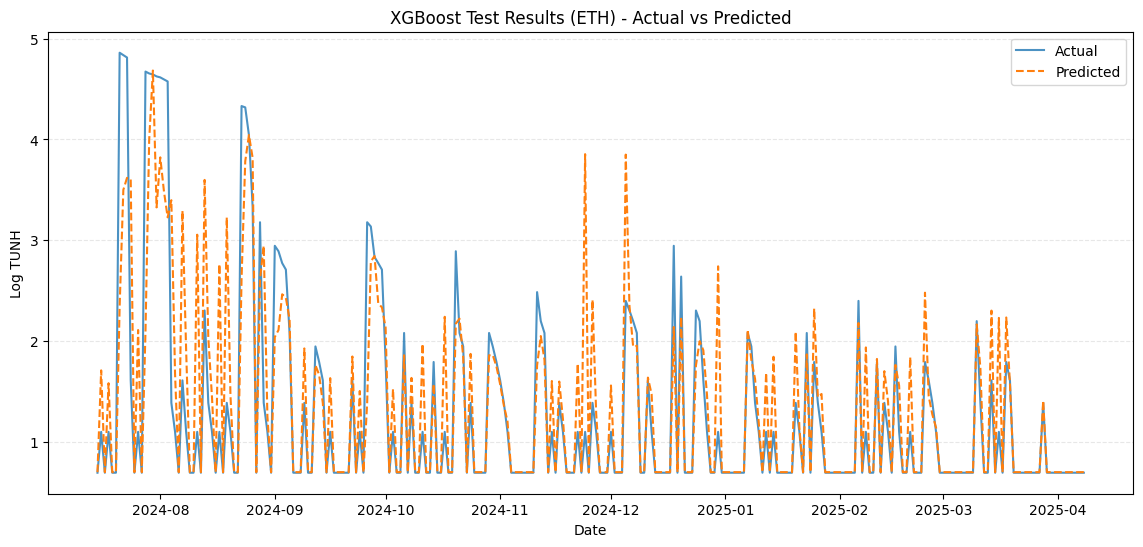

In [57]:
plot_log_results(
    df_test_results,
    "XGBoost Test Results (ETH) - Actual vs Predicted",
    "Log TUNH",
    'Plots/6. test results/3. xgb/3a. test_results_log_eth.png'
)

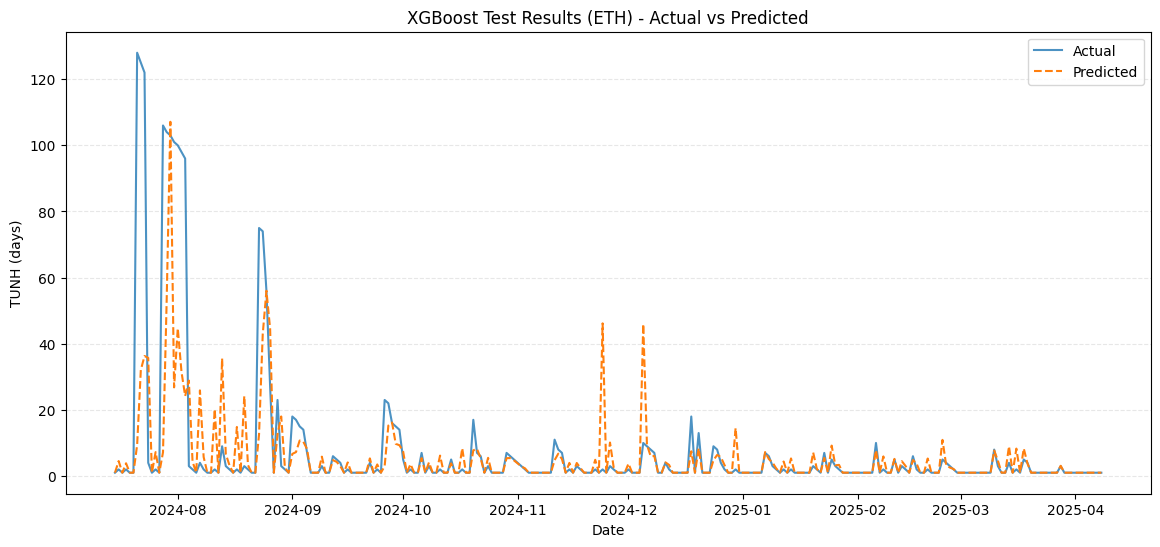

In [58]:
plot_results(
    df_test_days,
    "XGBoost Test Results (ETH) - Actual vs Predicted",
    "TUNH (days)",
    'Plots/6. test results/3. xgb/3b. test_results_eth.png'
)

### <span style='color:darkgoldenrod'>**Model 4:** LSTM</span>

#### **Step 1:** Split the data for the LSTM (80% Train - Next 10% Validation - 10% Test)

In [59]:
# ─── 1) SPLIT & SCALE ──────────────────────────────────────────────────────
split_index = int(len(X) * 0.80)
wf_index    = int(len(X) * 0.90)

X_tr_raw = X.iloc[:split_index]
X_wf_raw = X.iloc[split_index:wf_index]
X_te_raw = X.iloc[wf_index:]

scaler = StandardScaler().fit(X_tr_raw)
X_train_lstm  = pd.DataFrame(scaler.transform(X_tr_raw), index=X_tr_raw.index,  columns=X.columns)
X_wf_lstm  = pd.DataFrame(scaler.transform(X_wf_raw), index=X_wf_raw.index,  columns=X.columns)
X_test_lstm  = pd.DataFrame(scaler.transform(X_te_raw), index=X_te_raw.index,  columns=X.columns)

y_train_lstm = y.reindex(X_train_lstm.index).dropna()
X_train_lstm = X_train_lstm.loc[y_train_lstm.index]
y_wf_lstm = y.reindex(X_wf_lstm.index).dropna()
X_wf_lstm = X_wf_lstm.loc[y_wf_lstm.index]
y_test_lstm = y.reindex(X_test_lstm.index).dropna()
X_test_lstm = X_test_lstm.loc[y_test_lstm.index]

#### **Step 2:** LSTM Feature Selection

In [60]:
# 2) FEATURE SELECTION
selected = select_features(X_train_lstm, y_train_lstm).columns
X_train_selected_lstm = X_train_lstm[selected]
X_wf_selected_lstm = X_wf_lstm[selected]
X_test_selected_lstm = X_test_lstm[selected]

#### **Step 3:** LSTM Hyperparameter Tuning

In [61]:
# ─── 3) ADD REGIME FLAG AS FEATURE ────────────────────────────────────────
# regime = 1 if next‐day TUNH faster (i.e. diff<0), else 0
reg_tr = (y_train_lstm.diff().shift(-1) < 0).astype(int)
reg_wf = (y_wf_lstm.diff().shift(-1) < 0).astype(int)
reg_te = (y_test_lstm.diff().shift(-1) < 0).astype(int)

X_train_reg_lstm = X_train_selected_lstm.copy(); X_train_reg_lstm['regime'] = reg_tr
X_wf_reg_lstm = X_wf_selected_lstm.copy(); X_wf_reg_lstm['regime'] = reg_wf
X_test_reg_lstm = X_test_selected_lstm.copy(); X_test_reg_lstm['regime'] = reg_te

In [62]:
X_train_int_lstm = expand_with_regime_interactions(X_train_selected_lstm, reg_tr)
X_wf_int_lstm = expand_with_regime_interactions(X_wf_selected_lstm, reg_wf)
X_test_int_lstm = expand_with_regime_interactions(X_test_selected_lstm, reg_te)

In [63]:
# shape vars (from SNIPPET 1+2/3)
n_features = X_train_int_lstm.shape[1]
timesteps  = 1

def lstm_builder(hp):
    model = Sequential()
    model.add(Input(shape=(timesteps, n_features)))
    # first LSTM
    model.add(LSTM(
        units=hp.Int("units1", min_value=32, max_value=128, step=32),
        return_sequences=True
    ))
    model.add(Dropout(hp.Float("dropout1", 0.1, 0.5, step=0.1)))
    # optional second LSTM
    if hp.Boolean("stack_second", default=True):
        model.add(LSTM(
            units=hp.Int("units2", min_value=16, max_value=64, step=16),
            return_sequences=False
        ))
        model.add(Dropout(hp.Float("dropout2", 0.1, 0.5, step=0.1)))
    # output
    model.add(Dense(1))
    model.compile(
        optimizer=Adam(
            hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
        ),
        loss="mean_squared_error"
    )
    return model

In [64]:
# set up tuner
tuner = kt.RandomSearch(
    lstm_builder,
    objective="val_loss",
    max_trials=10,
    executions_per_trial=1,
    directory="tuner_logs_eth",
    project_name="eth_lstm_split"
)

# prepare 3D input
X_tr_3d = X_train_int_lstm.values.reshape((-1, timesteps, n_features))
y_tr_arr = y_train_lstm.values

# tune on the entire train set (you could also limit to bull‑slice)
tuner.search(
    X_tr_3d, y_tr_arr,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[EarlyStopping(monitor="val_loss", patience=5)]
)

# retrieve best hyperparameters
best_hps = tuner.get_best_hyperparameters(1)[0]
print("🔍 Best LSTM hyperparameters:", best_hps.values)

Reloading Tuner from tuner_logs_eth/eth_lstm_split/tuner0.json
🔍 Best LSTM hyperparameters: {'units1': 64, 'dropout1': 0.30000000000000004, 'stack_second': True, 'units2': 16, 'dropout2': 0.2, 'learning_rate': 0.0009018154359590027}


#### **Step 4:** LSTM Training

In [65]:
# rebuild specialists with best_hps
def build_best_lstm():
    model = lstm_builder(best_hps)
    return model

best_lstm = build_best_lstm()

best_lstm.fit(
    X_tr_3d, y_tr_arr,
    epochs=50, batch_size=32,
    callbacks=[EarlyStopping(monitor="loss", patience=3)],
    verbose=1
)

Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.6748
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2180
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9208
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8467
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8227
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7790
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7064
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5923
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6120
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5642
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5798
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5239
Epoch 13/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4586
Epoch 14/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4467
Epoch 15/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4280
Epoch 16/50
67/67 ━

#### **Step 5:** LSTM Walk-Forward Validation

In [66]:
# ─── C) WALK‑FORWARD EVALUATION ─────────────────────────────────────────────
for start in range(0, len(X_wf_int_lstm), window_size):
    # 1) select the window
    idx    = X_wf_int_lstm.index[start:start+window_size]
    X_win  = X_wf_int_lstm.loc[idx]
    y_win  = y_wf_lstm.loc[idx]

    # 2) reshape to (batch, timesteps=1, features)
    X_win_3d = X_win.values.reshape((len(X_win), 1, X_win.shape[1]))

    # 3) predict
    preds = best_lstm.predict(X_win_3d, verbose=0).flatten()

    # 4) store and report
    fold_preds.append(preds)
    fold_actuals.append(y_win.values)
    fold_indices.append(idx)

    MAE, RMSE, MAPE, DA = calculate_metrics(y_win.values, preds)
    print(f"WF ending {idx[-1]}: MAE={MAE:.4f}, RMSE={RMSE:.4f}, "
        f"MAPE={MAPE:.2f}%, DA={DA:.2f}%")

WF ending 2023-12-10: MAE=0.3476, RMSE=0.6114, MAPE=26.36%, DA=67.35%
WF ending 2024-01-29: MAE=0.2848, RMSE=0.4829, MAPE=15.96%, DA=59.18%
WF ending 2024-03-19: MAE=0.4093, RMSE=0.9150, MAPE=21.32%, DA=44.90%
WF ending 2024-05-08: MAE=0.3584, RMSE=0.6152, MAPE=20.04%, DA=55.10%
WF ending 2024-06-27: MAE=0.6183, RMSE=1.1966, MAPE=35.32%, DA=69.39%
WF ending 2024-07-14: MAE=0.3033, RMSE=0.5198, MAPE=18.37%, DA=50.00%


#### **Step 6:** Evaluate LSTM

In [67]:
n_feats = X_train_int_lstm.shape[1]

X_train_int_3d = X_train_int_lstm.values.reshape(
    (len(X_train_int_lstm), 1, n_feats)
)
X_test_int_3d  = X_test_int_lstm.values.reshape(
    (len(X_test_int_lstm), 1, n_feats)
)

# 2) predict and flatten to 1-D
y_train_pred_lstm = best_lstm.predict(X_train_int_3d, verbose=0).flatten()
y_test_pred_lstm  = best_lstm.predict(X_test_int_3d,  verbose=0).flatten()

# 3) compute metrics
MAE_train_lstm, RMSE_train_lstm, MAPE_train_lstm, DA_train_lstm = \
    calculate_metrics(y_train_lstm.values, y_train_pred_lstm)

MAE_test_lstm,  RMSE_test_lstm,  MAPE_test_lstm,  DA_test_lstm  = \
    calculate_metrics(y_test_lstm.values,  y_test_pred_lstm)

# 4) print
print("LSTM Train Metrics:")
print(f" MAE={MAE_train_lstm:.5f}, RMSE={RMSE_train_lstm:.5f}, MAPE={MAPE_train_lstm:.2f}%, DA={DA_train_lstm:.2f}%\n")

print("LSTM Test Metrics:")
print(f" MAE={MAE_test_lstm:.5f}, RMSE={RMSE_test_lstm:.5f}, MAPE={MAPE_test_lstm:.2f}%, DA={DA_test_lstm:.2f}%")

LSTM Train Metrics:
 MAE=0.16245, RMSE=0.30601, MAPE=9.40%, DA=66.43%

LSTM Test Metrics:
 MAE=0.35519, RMSE=0.74112, MAPE=23.11%, DA=57.68%


In [68]:
# 1) WALK‑FORWARD DataFrame
#   - y_wf_all, y_wf_pred, idx_wf_all came from the regime‑split loop
df_wf_results = pd.DataFrame({
    "Actual": np.concatenate(fold_actuals),
    "Predicted": np.concatenate(fold_preds)
}, index=pd.DatetimeIndex(np.concatenate(fold_indices)))

# 2) FINAL TEST DataFrame
#   - y_te and pred_te are your true & predicted log‑TUNH for the test period
df_test_results = pd.DataFrame({
    "Actual":  y_test_lstm.values,
    "Predicted": y_test_pred_lstm
}, index=X_test_selected_lstm.index)

# 3) convert back to days
df_test_days = df_test_results.copy()
df_test_days["Actual_days"]    = np.expm1(df_test_days["Actual"])
df_test_days["Predicted_days"] = np.expm1(df_test_days["Predicted"])
print("\nTest Results (in days):")
print(df_test_days.head())


Test Results (in days):
              Actual  Predicted  Actual_days  Predicted_days
last_date                                                   
2024-07-15  0.693147   0.657801          1.0        0.930543
2024-07-16  1.098612   1.895541          2.0        5.656150
2024-07-17  0.693147   0.677384          1.0        0.968721
2024-07-18  1.098612   1.169397          2.0        2.220051
2024-07-19  0.693147   0.661062          1.0        0.936849


#### **Step 7:** LSTM Plots

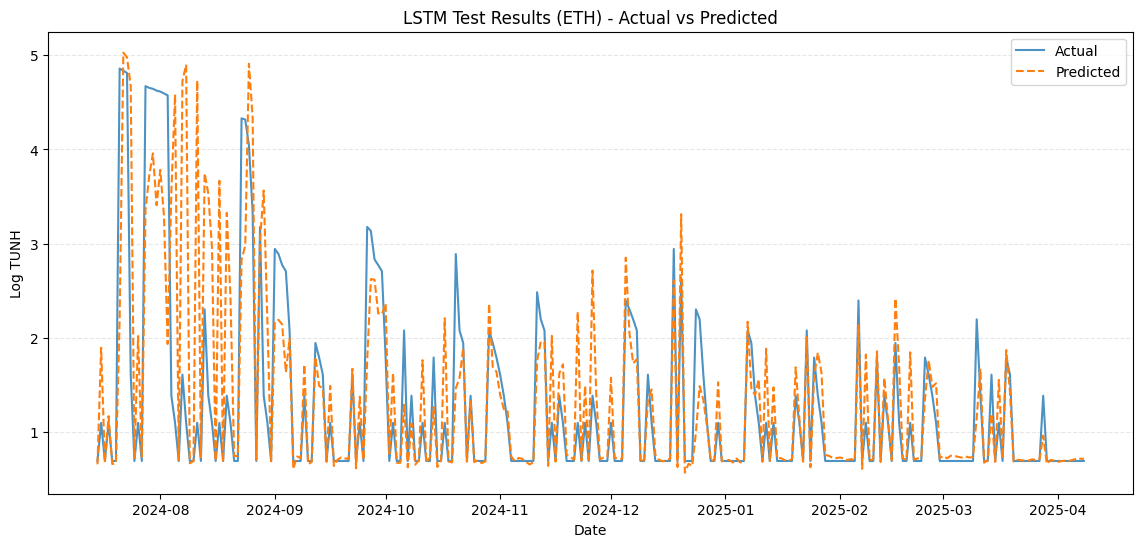

In [69]:
plot_log_results(
    df_test_results,
    "LSTM Test Results (ETH) - Actual vs Predicted",
    "Log TUNH",
    'Plots/6. test results/4. lstm/3a. test_results_log_eth.png'
)

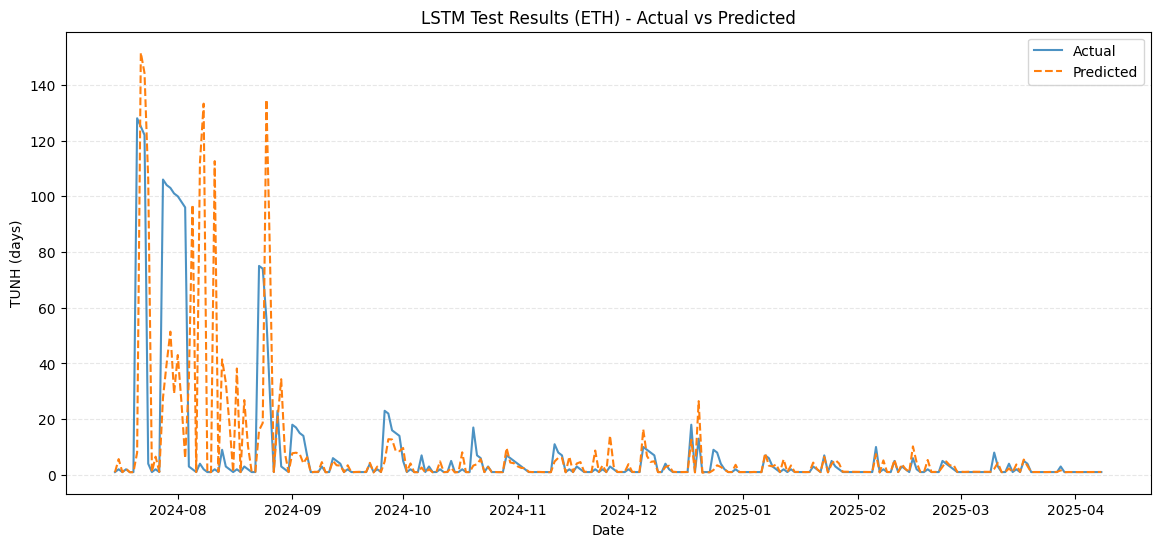

In [70]:
plot_results(
    df_test_days,
    "LSTM Test Results (ETH) - Actual vs Predicted",
    "TUNH (days)",
    'Plots/6. test results/4. lstm/3b. test_results_eth.png'
)

### <span style='color:darkgoldenrod'>**Model 5:** MLP</span>

#### **Step 1:** Split the data for the MLP (80% Train - Next 10% Validation - 10% Test)

In [71]:
# ─── 1) SPLIT & SCALE ──────────────────────────────────────────────────────
split_index = int(len(X) * 0.80)
wf_index    = int(len(X) * 0.90)

X_tr_raw = X.iloc[:split_index]
X_wf_raw = X.iloc[split_index:wf_index]
X_te_raw = X.iloc[wf_index:]

scaler = StandardScaler().fit(X_tr_raw)
X_train_mlp  = pd.DataFrame(scaler.transform(X_tr_raw), index=X_tr_raw.index,  columns=X.columns)
X_wf_mlp  = pd.DataFrame(scaler.transform(X_wf_raw), index=X_wf_raw.index,  columns=X.columns)
X_test_mlp  = pd.DataFrame(scaler.transform(X_te_raw), index=X_te_raw.index,  columns=X.columns)

y_train_mlp = y.reindex(X_train_mlp.index).dropna()
X_train_mlp = X_train_mlp.loc[y_train_mlp.index]
y_wf_mlp = y.reindex(X_wf_mlp.index).dropna()
X_wf_mlp = X_wf_mlp.loc[y_wf_mlp.index]
y_test_mlp = y.reindex(X_test_mlp.index).dropna()
X_test_mlp = X_test_mlp.loc[y_test_mlp.index]

#### **Step 2:** MLP Feature Selection

In [72]:
# 2) FEATURE SELECTION
selected = select_features(X_train_mlp, y_train_mlp).columns
X_train_selected_mlp = X_train_mlp[selected]
X_wf_selected_mlp = X_wf_mlp[selected]
X_test_selected_mlp = X_test_mlp[selected]

#### **Step 3:** MLP Build and Train

In [73]:
# ─── 3) ADD REGIME FLAG AS FEATURE ────────────────────────────────────────
# regime = 1 if next‐day TUNH faster (i.e. diff<0), else 0
reg_tr = (y_train_mlp.diff().shift(-1) < 0).astype(int)
reg_wf = (y_wf_mlp.diff().shift(-1) < 0).astype(int)
reg_te = (y_test_mlp.diff().shift(-1) < 0).astype(int)

X_train_reg_mlp = X_train_selected_mlp.copy(); X_train_reg_mlp['regime'] = reg_tr
X_wf_reg_mlp = X_wf_selected_mlp.copy(); X_wf_reg_mlp['regime'] = reg_wf
X_test_reg_mlp = X_test_selected_mlp.copy(); X_test_reg_mlp['regime'] = reg_te

In [74]:
X_train_int_mlp = expand_with_regime_interactions(X_train_selected_mlp, reg_tr)
X_wf_int_mlp = expand_with_regime_interactions(X_wf_selected_mlp, reg_wf)
X_test_int_mlp = expand_with_regime_interactions(X_test_selected_mlp, reg_te)

In [75]:
def build_mlp(input_dim, hidden_units=[512,256,128], dropout_rate=0.3, lr=1e-3):
    inp = Input(shape=(input_dim,))
    x = inp
    for h in hidden_units:
        x = Dense(h, activation="relu")(x)
        x = Dropout(dropout_rate)(x)
    out = Dense(1, activation="linear")(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(lr),
                loss="mean_absolute_error")
    return model

In [76]:
mlp = build_mlp(input_dim=X_train_int_mlp.shape[1])
mlp.fit(X_train_int_mlp.values, y_train_mlp.values,
        validation_data=(X_wf_int_mlp.values, y_wf_mlp.values),
        epochs=50,
        batch_size=32,
        verbose=2)

Epoch 1/50
67/67 - 2s - 27ms/step - loss: 0.8492 - val_loss: 0.4643
Epoch 2/50
67/67 - 1s - 11ms/step - loss: 0.6658 - val_loss: 0.5174
Epoch 3/50
67/67 - 1s - 11ms/step - loss: 0.5975 - val_loss: 0.4448
Epoch 4/50
67/67 - 1s - 8ms/step - loss: 0.5836 - val_loss: 0.4949
Epoch 5/50
67/67 - 1s - 8ms/step - loss: 0.5539 - val_loss: 0.4542
Epoch 6/50
67/67 - 1s - 8ms/step - loss: 0.5186 - val_loss: 0.4421
Epoch 7/50
67/67 - 0s - 5ms/step - loss: 0.5082 - val_loss: 0.4731
Epoch 8/50
67/67 - 0s - 5ms/step - loss: 0.4921 - val_loss: 0.4386
Epoch 9/50
67/67 - 0s - 5ms/step - loss: 0.4852 - val_loss: 0.4011
Epoch 10/50
67/67 - 0s - 6ms/step - loss: 0.4566 - val_loss: 0.3789
Epoch 11/50
67/67 - 0s - 6ms/step - loss: 0.4564 - val_loss: 0.4490
Epoch 12/50
67/67 - 0s - 5ms/step - loss: 0.4588 - val_loss: 0.3982
Epoch 13/50
67/67 - 0s - 7ms/step - loss: 0.4365 - val_loss: 0.4015
Epoch 14/50
67/67 - 0s - 6ms/step - loss: 0.4392 - val_loss: 0.4034
Epoch 15/50
67/67 - 0s - 5ms/step - loss: 0.4201 - val

#### **Step 4:** MLP Walk-Forward Validation

In [77]:
window_size = 50
wf_preds, wf_actuals, wf_indices = [], [], []
for start in range(0, len(X_wf_int_mlp), 50):
    idx = X_wf_int_mlp.index[start:start+window_size]
    end = min(start+50, len(X_wf_int_mlp))
    p = mlp.predict(X_wf_int_mlp.values[start:end]).flatten()
    wf_preds.append(p)
    wf_actuals.append(y_wf_mlp.values[start:end])
    wf_indices.append(idx)
    MAE_wf, RMSE_wf, MAPE_wf, DA_wf = calculate_metrics(np.concatenate(wf_actuals), 
                                                        np.concatenate(wf_preds))
    print(f"WF ending {X_wf_int_mlp.index[end-1]}: MAE={MAE_wf:.4f}, RMSE={RMSE_wf:.4f}, MAPE={MAPE_wf:.2f}%, DA={DA_wf:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
WF ending 2023-12-10: MAE=0.3113, RMSE=0.6244, MAPE=19.26%, DA=93.88%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
WF ending 2024-01-29: MAE=0.3313, RMSE=0.6139, MAPE=17.94%, DA=85.86%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
WF ending 2024-03-19: MAE=0.3012, RMSE=0.6392, MAPE=14.84%, DA=87.25%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
WF ending 2024-05-08: MAE=0.3094, RMSE=0.6335, MAPE=14.75%, DA=80.90%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
WF ending 2024-06-27: MAE=0.3653, RMSE=0.7511, MAPE=17.76%, DA=79.92%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
WF ending 2024-07-14: MAE=0.3474, RMSE=0.7276, MAPE=16.91%, DA=79.70%


#### **Step 5:** Evaluate MLP

In [78]:
y_train_pred_mlp = mlp.predict(X_train_int_mlp.values).flatten()
y_test_pred_mlp = mlp.predict(X_test_int_mlp.values).flatten()

MAE_train_mlp, RMSE_train_mlp, MAPE_train_mlp, DA_train_mlp = \
    calculate_metrics(y_train_mlp.values, y_train_pred_mlp)
MAE_test_mlp, RMSE_test_mlp, MAPE_test_mlp, DA_test_mlp = \
    calculate_metrics(y_test_mlp.values, y_test_pred_mlp)

print("MLP Train Metrics:")
print(f" MAE={MAE_train_mlp:.5f}, RMSE={RMSE_train_mlp:.5f}, MAPE={MAPE_train_mlp:.2f}%, DA={DA_train_mlp:.2f}%\n")

print("MLP Test Metrics:")
print(f" MAE={MAE_test_mlp:.5f}, RMSE={RMSE_test_mlp:.5f}, MAPE={MAPE_test_mlp:.2f}%, DA={DA_test_mlp:.2f}%")

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MLP Train Metrics:
 MAE=0.26175, RMSE=0.57283, MAPE=11.70%, DA=86.58%

MLP Test Metrics:
 MAE=0.33994, RMSE=0.68803, MAPE=17.46%, DA=89.51%


In [79]:
# 1) WALK‑FORWARD DataFrame
#   - y_wf_all, y_wf_pred, idx_wf_all came from the regime‑split loop
df_wf_results = pd.DataFrame({
    "Actual": np.concatenate(wf_actuals),
    "Predicted": np.concatenate(wf_preds)
}, index=pd.DatetimeIndex(np.concatenate(wf_indices)))

# 2) FINAL TEST DataFrame
#   - y_te and pred_te are your true & predicted log‑TUNH for the test period
df_test_results = pd.DataFrame({
    "Actual":  y_test_mlp.values,
    "Predicted": y_test_pred_mlp
}, index=X_test_selected_mlp.index)

# 3) convert back to days
df_test_days = df_test_results.copy()
df_test_days["Actual_days"]    = np.expm1(df_test_days["Actual"])
df_test_days["Predicted_days"] = np.expm1(df_test_days["Predicted"])
print("\nTest Results (in days):")
print(df_test_days.head())


Test Results (in days):
              Actual  Predicted  Actual_days  Predicted_days
last_date                                                   
2024-07-15  0.693147   0.695533          1.0        1.004777
2024-07-16  1.098612   1.550239          2.0        3.712597
2024-07-17  0.693147   0.695533          1.0        1.004777
2024-07-18  1.098612   0.981649          2.0        1.668854
2024-07-19  0.693147   0.695533          1.0        1.004777


#### **Step 6:** MLP Plots

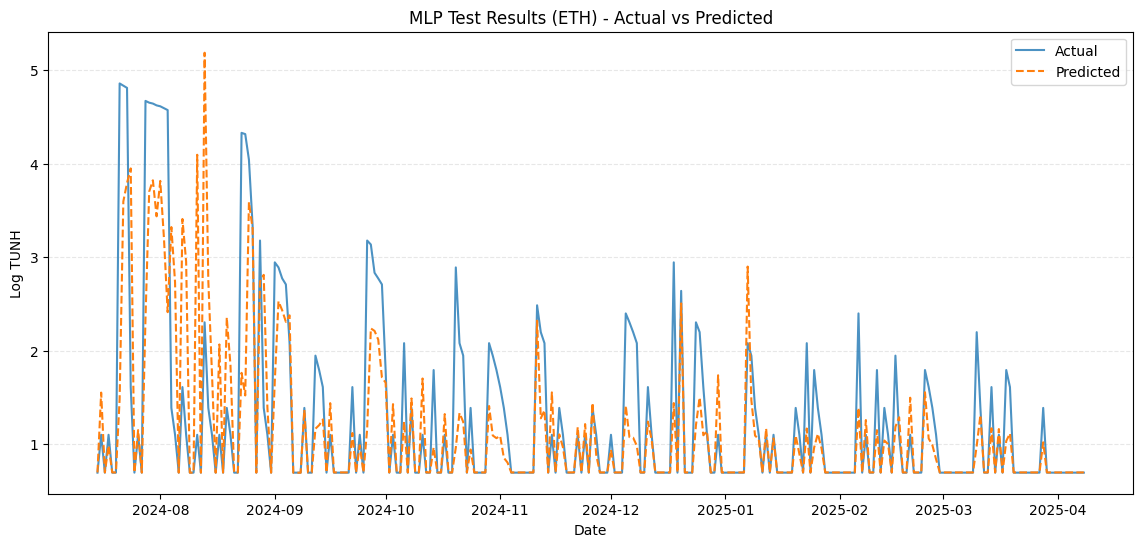

In [80]:
plot_log_results(
    df_test_results,
    "MLP Test Results (ETH) - Actual vs Predicted",
    "Log TUNH",
    'Plots/6. test results/5. mlp/3a. test_results_log_eth.png'
)

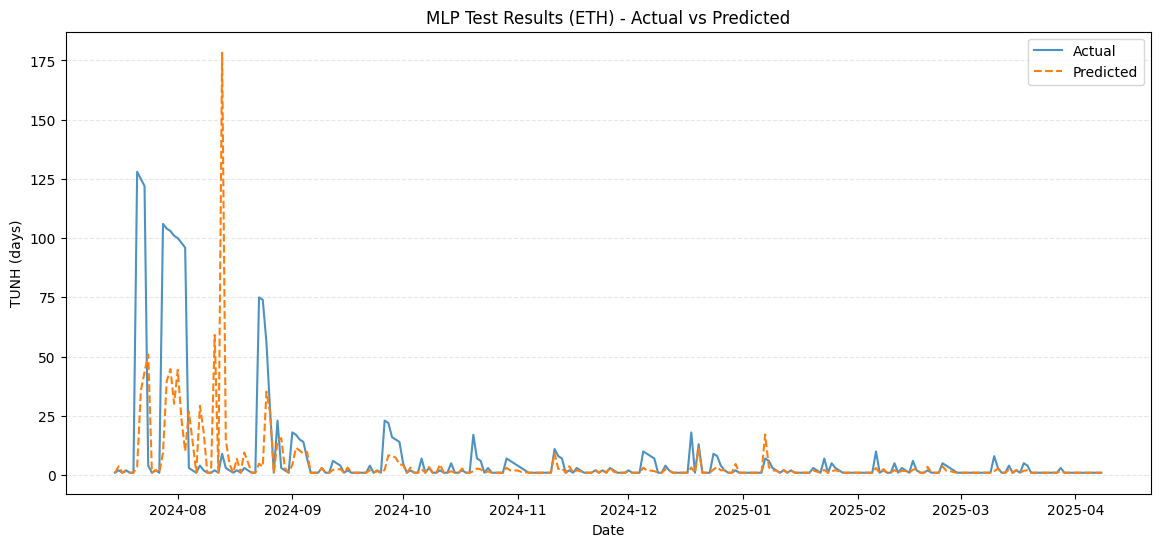

In [81]:
plot_results(
    df_test_days,
    "MLP Test Results (ETH) - Actual vs Predicted",
    "TUNH (days)",
    'Plots/6. test results/5. mlp/3b. test_results_eth.png'
)

## <span style='color:brown'>**Stage C:** Comparison</span>

In [82]:
# Final metrics
model_names = ['SVR', 'Random Forest', 'XGBoost', 'LSTM', 'MLP']

train_rmse = [RMSE_train_svr, RMSE_train_rf, RMSE_train_xgb, RMSE_train_lstm, RMSE_train_mlp]
test_rmse = [RMSE_test_svr, RMSE_test_rf, RMSE_test_xgb, RMSE_test_lstm, RMSE_test_mlp]

train_mae = [MAE_train_svr, MAE_train_rf, MAE_train_xgb, MAE_train_lstm, MAE_train_mlp]
test_mae = [MAE_test_svr, MAE_test_rf, MAE_test_xgb, MAE_test_lstm, MAE_test_mlp]

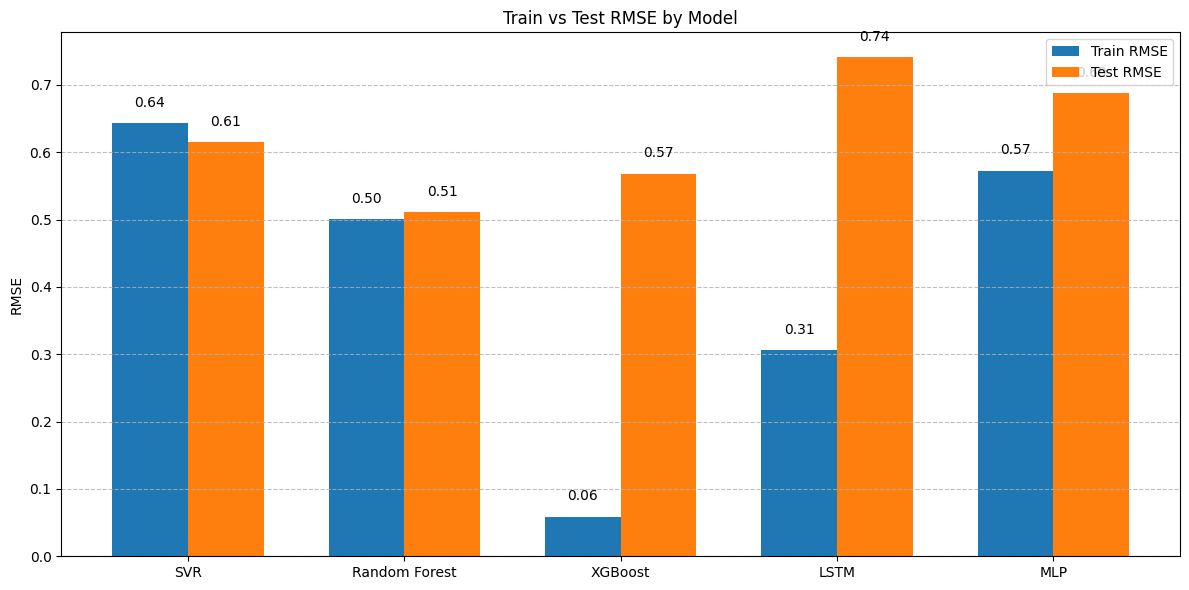

In [83]:
x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, train_rmse, width, label='Train RMSE')
bars2 = ax.bar(x + width/2, test_rmse, width, label='Test RMSE')

ax.set_ylabel('RMSE')
ax.set_title('Train vs Test RMSE by Model')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()
ax.grid(axis='y',linestyle='--', alpha=0.8)

# Annotate bars
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom')

plt.savefig('Plots/7. comparisons/3a. summary_rmse_eth.png', dpi=300)
plt.tight_layout()
plt.show()

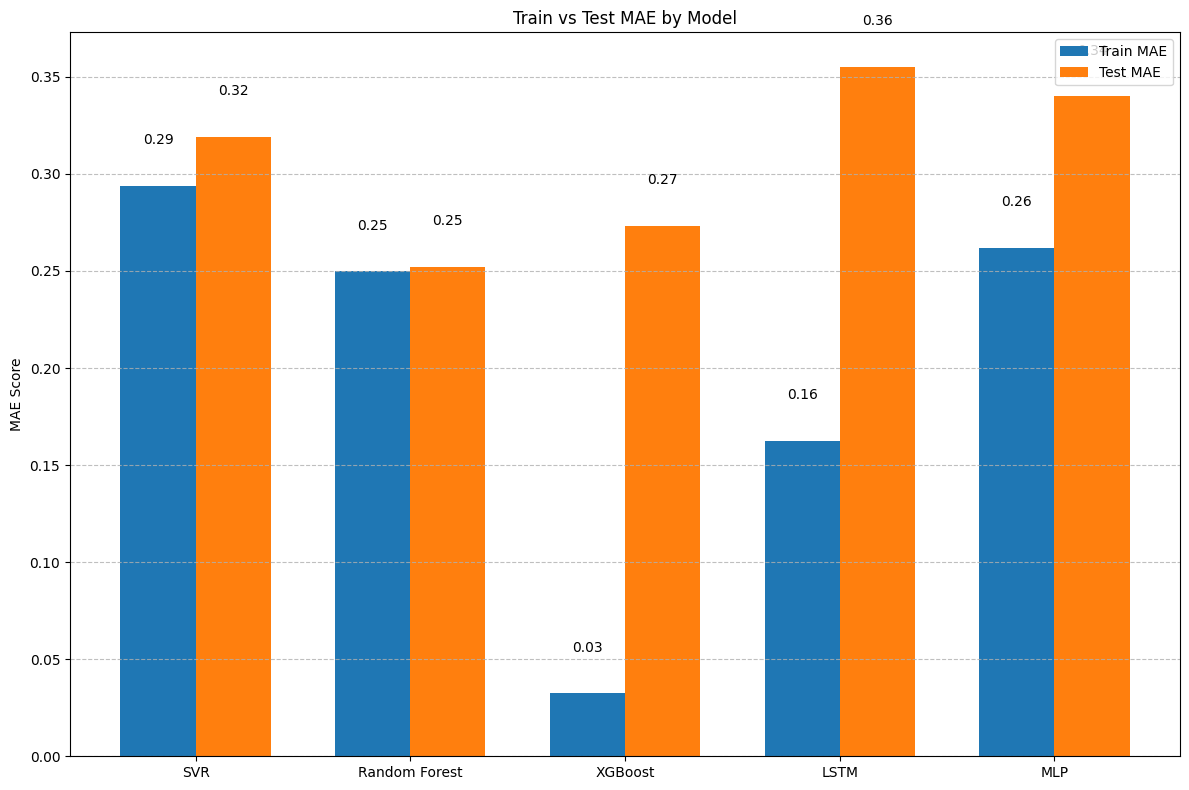

In [84]:
fig, ax = plt.subplots(figsize=(12, 8))
bars1 = ax.bar(x - width/2, train_mae, width, label='Train MAE')
bars2 = ax.bar(x + width/2, test_mae, width, label='Test MAE')

ax.set_ylabel('MAE Score')
ax.set_title('Train vs Test MAE by Model')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()
ax.grid(axis='y',linestyle='--', alpha=0.8)

# Annotate bars
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom')

plt.savefig('Plots/7. comparisons/3b. summary_mae_eth.png', dpi=300)
plt.tight_layout()
plt.show()

# **RQ2:** Feature Selection & Interpretability

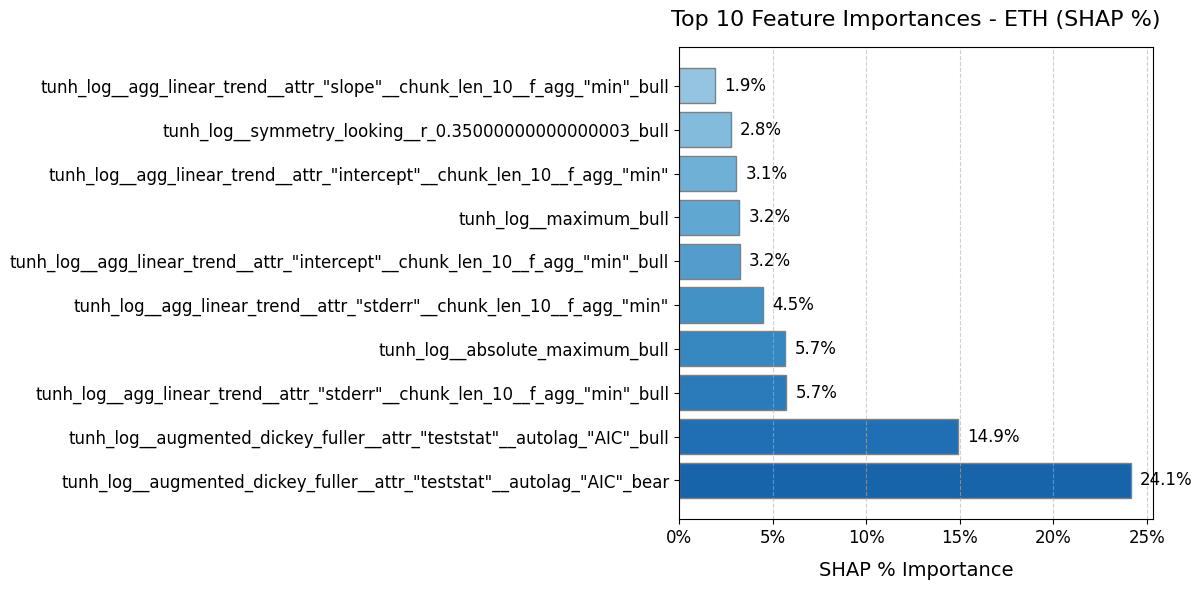

In [161]:
# 1) build a TreeExplainer
explainer = shap.TreeExplainer(best_rf)

# 2) get SHAP values for your training set
#    (for regression single‐output model this returns a (n_samples, n_features) array)
shap_vals = explainer.shap_values(X_train_int_rf)

# 3) mean absolute per feature
mean_abs_shap = np.abs(shap_vals).mean(axis=0)
shap_imp = pd.Series(mean_abs_shap, index=X_train_int_rf.columns)

# 4) to percentages
shap_imp_pct = 100 * shap_imp / shap_imp.sum()

# 5) top 10
top10_shap = shap_imp_pct.sort_values(ascending=False).head(10)

# 6) plot
features = top10_shap.index.tolist()
values   = top10_shap.values

# reverse for barh (so largest at top)
features = features[::-1]
values   = values[::-1]

# build a blue gradient
cmap = plt.get_cmap("Blues")
colors = cmap(np.linspace(0.4, 0.8, len(values)))

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(features, values, color=colors, edgecolor="gray")

# add annotations
for bar, val in zip(bars, values):
    ax.text(
        bar.get_width() + 0.5,               # x position: a little right of bar
        bar.get_y() + bar.get_height() / 2,  # y position: center of bar
        f"{val:.1f}%", 
        va="center", 
        fontsize=12
    )

# styling
ax.set_xlabel("SHAP % Importance", fontsize=14, labelpad=10)
ax.set_title("Top 10 Feature Importances - ETH (SHAP %)", fontsize=16, pad=15)
ax.xaxis.set_major_formatter(lambda x, pos: f"{x:.0f}%")
ax.grid(axis="x", linestyle="--", alpha=0.6)
ax.invert_yaxis()  # largest on top

# tick params
ax.tick_params(axis="y", labelsize=12)
ax.tick_params(axis="x", labelsize=12)

plt.savefig('Plots/8. feature importance/3. shap_rf_eth.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()